# Dataset

In [1]:
import os
import torch
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision
from torchvision import transforms as T
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [2]:
class GAN_Dataset(Dataset):
    def __init__(self, data, ir_data, mask_data, new_height, new_width):
        '''
        data - train data path
        '''
        self.train_data = data
        self.train_ir_data = ir_data
        self.train_mask_data = mask_data
        self.new_height = new_height
        self.new_width = new_width
        
        self.images = sorted(os.listdir(self.train_data))
        self.irs = sorted(os.listdir(self.train_ir_data))
        self.masks = sorted(os.listdir(self.train_mask_data))
        
    def __len__(self):
        
        return len(self.images)
        
    def __getitem__(self,idx):
        
        image_name = os.path.join(self.train_data, self.images[idx])
        img = Image.open(image_name)
        #img = img.convert('L')
        img = img.convert('RGB')
        resize = T.Resize((self.new_height, self.new_width))
        img = resize(img)
        trans = T.ToTensor()
        img = trans(img)
        
        ir_name = os.path.join(self.train_ir_data, self.irs[idx])
        ir = Image.open(ir_name)
        ir = ir.convert('L')
        ir = ir.convert('RGB')
        resize = T.Resize((self.new_height, self.new_width))
        ir = resize(ir)
        trans = T.ToTensor()
        ir = trans(ir)
        
        mask_name = os.path.join(self.train_mask_data, self.masks[idx])
        mask = Image.open(mask_name)
        mask = mask.convert('RGB')
        resize = T.Resize((self.new_height, self.new_width))
        mask = resize(mask)
        trans = T.ToTensor()
        mask = trans(mask)

        return img, ir, mask

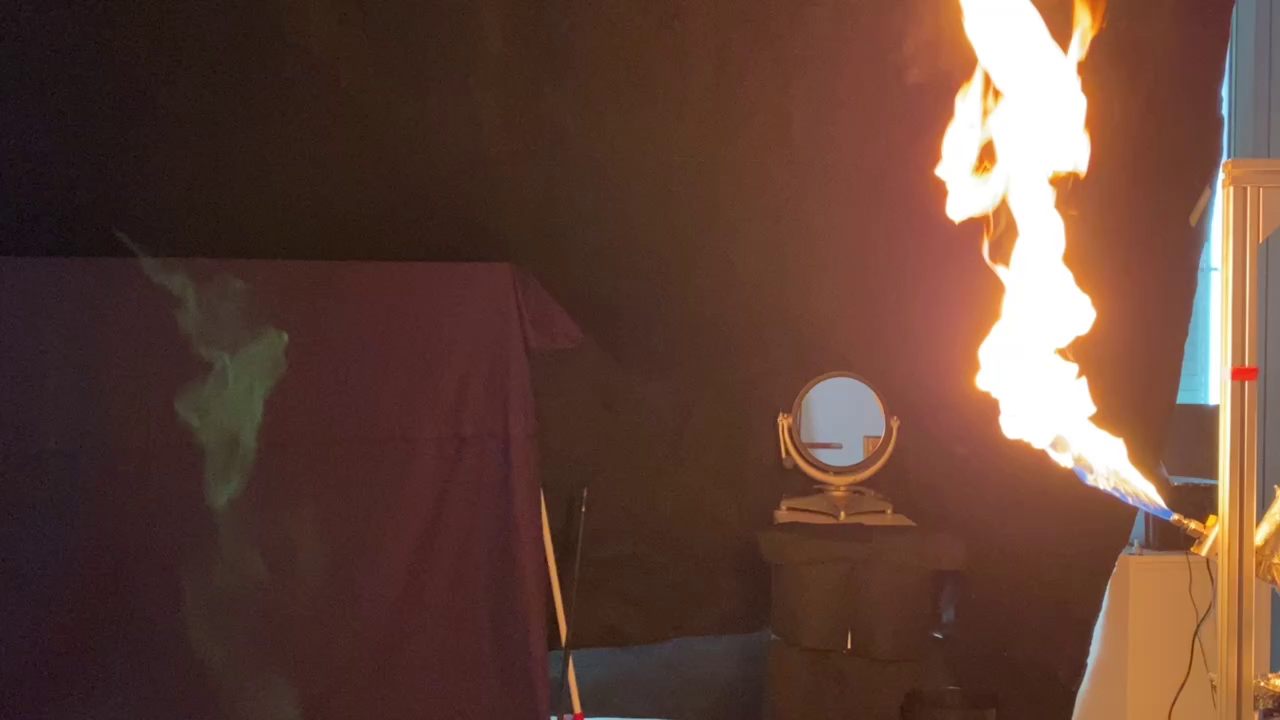

In [3]:
example_img = Image.open('Visible_match/0000.png')
example_img

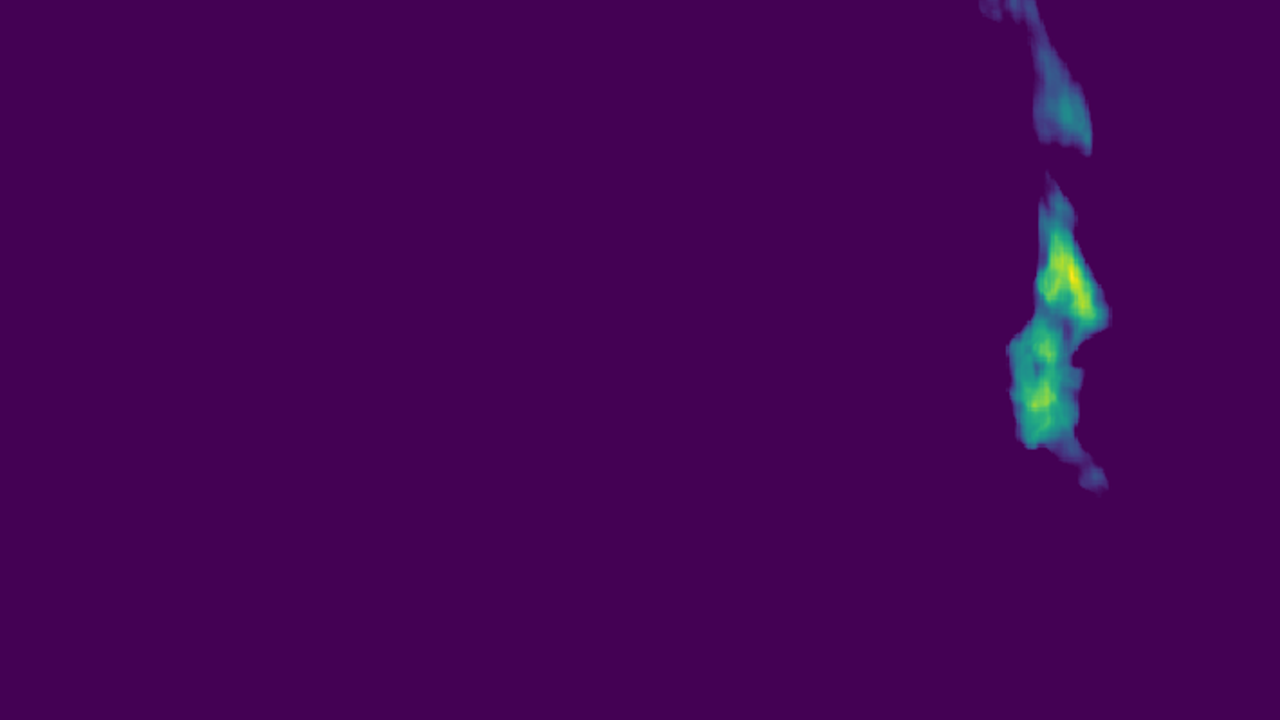

In [4]:
example_img = Image.open('IR_match_modified/00000076.png')
example_img

Full size 104
Train size:  66
Test size:  21
Val size:  17


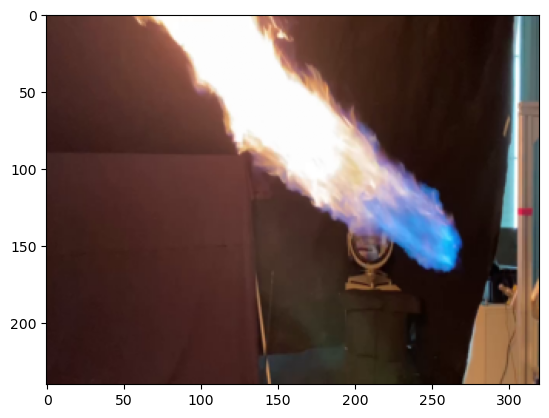

In [5]:
IMG_DIR = r"C:\Users\egard\Desktop\Github\Visible_match"
IR_DIR = r"C:\Users\egard\Desktop\Github\IR_match_modified"
MASK_DIR = r"C:\Users\egard\Desktop\Github\SegmentationClass"
full_dataset = GAN_Dataset(IMG_DIR,
                           IR_DIR,
                           MASK_DIR,
                              240,
                              320)

batch_size = 5
torch.manual_seed(77)

train_size = int(len(full_dataset)*0.8)
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

train_size = int(len(train_dataset)*0.8)
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = True)

print('Full size', len(full_dataset))
print('Train size: ', len(train_dataset))
print('Test size: ', len(test_dataset))
print('Val size: ', len(val_dataset))

imgs, irs, masks = next(iter(train_loader))

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

imshow(torchvision.utils.make_grid(imgs[0]))

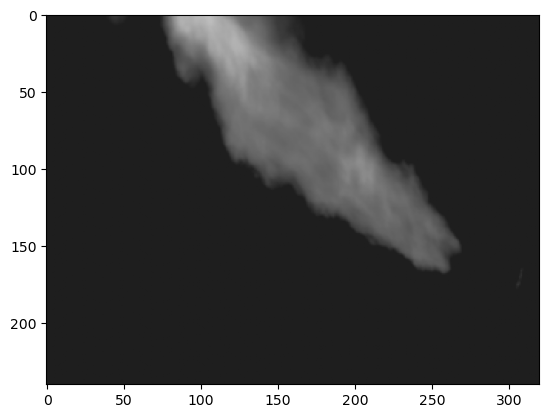

In [6]:
imshow(torchvision.utils.make_grid(irs[0]))

# Deep Learning Model

## GAN MODEL

## Generator

In [7]:
import torch.nn as nn

In [8]:
#Ma et al G2
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.generator = nn.Sequential(
                nn.Conv2d(6, 256, kernel_size = 5, stride = (1, 1), padding = 2),
                nn.BatchNorm2d(256),
                nn.LeakyReLU(),
                
                nn.Conv2d(256, 128, kernel_size = 5, stride = (1, 1), padding = 2),
                nn.BatchNorm2d(128),
                nn.LeakyReLU(),
            
                nn.Conv2d(128, 64, kernel_size = 3, stride = (1, 1), padding = 1),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(),
            
                nn.Conv2d(64, 32, kernel_size = 3, stride = (1, 1), padding = 1),
                nn.BatchNorm2d(32),
                nn.LeakyReLU(),
            
                nn.Conv2d(32, 3, kernel_size = 1, stride = (1, 1), padding = 0),
                nn.Tanh(),
        )
    def forward(self, x):
        return self.generator(x)

## Discriminator

In [9]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.discriminator = nn.Sequential(
                nn.Conv2d(3, 32, kernel_size = 3, stride = (2, 2), padding = 'valid'),
                nn.LeakyReLU(),
            
                nn.Conv2d(32, 64, kernel_size = 3, stride = (2, 2), padding = 'valid'),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(),
            
                nn.Conv2d(64, 128, kernel_size = 3, stride = (2, 2), padding = 'valid'),
                nn.BatchNorm2d(128),
                nn.LeakyReLU(),
            
                nn.Conv2d(128, 256, kernel_size = 3, stride = (2, 2), padding = 'valid'),
                nn.BatchNorm2d(256),
                nn.LeakyReLU(),
            
                nn.Flatten(),
                
                nn.Linear(256 * 14 * 19, 1)
        )
    def forward(self, x):
        return self.discriminator(x)

## Loss Functions

In [10]:
import torch.nn.functional as F

def gradient(img):
    filt = torch.tensor([
     [[[0.,1.,0.],[1.,-4.,1.],[0.,1.,0.]],
     [[0.,1.,0.],[1.,-4.,1.],[0.,1.,0.]],
     [[0.,1.,0.],[1.,-4.,1.],[0.,1.,0.]]]])
    
    filt = filt.to(device = device)
    img  = img.to(device = device)
    
    grad = F.conv2d(img, filt, stride=1, padding=1).cpu().detach().numpy()
    return grad


In [11]:
from numpy import linalg as LA
class Loss_G(nn.Module):
    def __init__(self, xi=0):
        super(Loss_G, self).__init__()
        self.xi = xi

    def forward(self, disc_out_g, ir_in, rgb_in, out_g):
        g_loss_1 = torch.mean((disc_out_g - ((torch.rand(rgb_in.shape[0], 1) * 0.5) + 0.7))**2)
        g_loss_2 = (1/(out_g.shape[2]*out_g.shape[3])) * (np.mean((   LA.norm((out_g - ir_in).cpu().detach().numpy())   )**2) + (self.xi * np.mean( ( LA.norm( (gradient(out_g) - gradient(rgb_in))) )**2)))
        total_loss = (g_loss_1) + 100*(g_loss_2)
        return total_loss

In [12]:
class Loss_D(nn.Module):
    def __init__(self):
        super(Loss_D, self).__init__()

    def forward(self, rgb_in, out_g):
        rgb_loss = torch.mean(torch.square(rgb_in - ((torch.rand(rgb_in.shape[0], 1) * 0.5) + 0.7)   ))

        g2_loss = torch.mean(torch.square(out_g - (torch.rand(rgb_in.shape[0], 1) * 0.3)))

        total_loss = rgb_loss + g2_loss

        return total_loss

# Training

In [13]:
import torch.optim as optim
from tqdm import tqdm
import seaborn as sns
import warnings
import sys
warnings.filterwarnings('ignore')
np.set_printoptions(threshold=sys.maxsize)
torch.cuda.empty_cache()

In [14]:
def train(generator, discriminator, loss_fn_g, loss_fn_d, lr, epochs, train_data, val_data, test_data, batch_size):
    optimizer_g = optim.Adam(generator.parameters(), lr =  lr)
    optimizer_d = optim.Adam(discriminator.parameters(), lr =  lr)
    scaler_g  = torch.cuda.amp.GradScaler()
    scaler_d  = torch.cuda.amp.GradScaler()
    lst_loss_g = []
    lst_loss_d = []
    mean_loss_g = 0
    mean_loss_d = 0
    lst_mean_loss_g = []
    lst_mean_loss_d = []
    val_lst_loss_g = []
    val_lst_loss_d = []
    val_mean_loss_g = 0
    val_mean_loss_d = 0
    val_lst_mean_loss_g = []
    val_lst_mean_loss_d = []
    test_lst_loss_g = []
    test_lst_loss_d = []
    test_mean_loss_g = 0
    test_mean_loss_d = 0
    test_lst_mean_loss_g = []
    test_lst_mean_loss_d = []
    
    for epoch in range(epochs):
        print("Epoch: ", epoch + 1)
        loop = tqdm(train_data)
        for mb, (visible, ir, mask) in enumerate(loop, start = 1):
            visible = visible.to(device = device)
            ir = ir.to(device = device)
            with torch.cuda.amp.autocast():
                
                generator_input = torch.cat([visible,ir],dim = 1).to(device = device)
                generator_output = generator(generator_input)
                discriminator_output_generator = discriminator(generator_output)
                discriminator_output_visible = discriminator(visible)
                
                visible = visible.cpu()
                ir = ir.cpu()
                generator_output = generator_output.cpu()
                discriminator_output_generator = discriminator_output_generator.cpu()
                discriminator_output_visible = discriminator_output_visible.cpu()
                
                loss_generator = loss_fn_g(discriminator_output_generator, ir, visible, generator_output).to(device = device)
                loss_discriminator = loss_fn_d(discriminator_output_visible, discriminator_output_generator).to(device = device)
        
            #Zero grad
            
            optimizer_g.zero_grad()
            optimizer_d.zero_grad()
            
            #Backpropagation
            
            scaler_g.scale(loss_generator).backward(retain_graph=True)
            scaler_d.scale(loss_discriminator).backward()
            
            #Update Parameters
            scaler_g.step(optimizer_g)
            scaler_g.update()
            scaler_d.step(optimizer_d)
            scaler_d.update()
        
            loop.set_postfix(loss_g = loss_generator.item(), loss_d = loss_discriminator.item())
            
        lst_loss_g = []
        lst_loss_d = []
        for i, data in enumerate(train_data, 0):
            visible, ir, mask = data
            visible = visible.to(device = device)
            ir = ir.to(device = device)
            with torch.no_grad():
                
                generator_input = torch.cat([visible,ir],dim = 1).to(device = device)
                generator_output = generator(generator_input)
                discriminator_output_generator = discriminator(generator_output)
                discriminator_output_visible = discriminator(visible)
                
                visible = visible.cpu()
                ir = ir.cpu()
                generator_output = generator_output.cpu()
                discriminator_output_generator = discriminator_output_generator.cpu()
                discriminator_output_visible = discriminator_output_visible.cpu()
                
                loss_generator = loss_fn_g(discriminator_output_generator, ir, visible, generator_output).cpu()
                loss_discriminator = loss_fn_d(discriminator_output_visible, discriminator_output_generator).cpu()
                
                lst_loss_g.append(loss_generator)
                lst_loss_d.append(loss_discriminator)
                
        
        mean_loss_g = np.mean(lst_loss_g)
        lst_mean_loss_g.append(mean_loss_g)
        mean_loss_d = np.mean(lst_loss_d)
        lst_mean_loss_d.append(mean_loss_d)
        
        val_lst_loss_g = []
        val_lst_loss_d = []
        for i, data in enumerate(val_data, 0):
            visible, ir, mask = data
            visible = visible.to(device = device)
            ir = ir.to(device = device)
            with torch.no_grad():
                
                generator_input = torch.cat([visible,ir],dim = 1).to(device = device)
                generator_output = generator(generator_input)
                discriminator_output_generator = discriminator(generator_output)
                discriminator_output_visible = discriminator(visible)
                
                visible = visible.cpu()
                ir = ir.cpu()
                generator_output = generator_output.cpu()
                discriminator_output_generator = discriminator_output_generator.cpu()
                discriminator_output_visible = discriminator_output_visible.cpu()
                
                val_loss_generator = loss_fn_g(discriminator_output_generator, ir, visible, generator_output).cpu()
                val_loss_discriminator = loss_fn_d(discriminator_output_visible, discriminator_output_generator).cpu()
                
                val_lst_loss_g.append(val_loss_generator)
                val_lst_loss_d.append(val_loss_discriminator)
                
        
        val_mean_loss_g = np.mean(val_lst_loss_g)
        val_lst_mean_loss_g.append(val_mean_loss_g)
        val_mean_loss_d = np.mean(val_lst_loss_d)
        val_lst_mean_loss_d.append(val_mean_loss_d)
        
        test_lst_loss_g = []
        test_lst_loss_d = []
        for i, data in enumerate(test_data, 0):
            visible, ir, mask = data
            visible = visible.to(device = device)
            ir = ir.to(device = device)
            with torch.no_grad():
                
                generator_input = torch.cat([visible,ir],dim = 1).to(device = device)
                generator_output = generator(generator_input)
                discriminator_output_generator = discriminator(generator_output)
                discriminator_output_visible = discriminator(visible)
                
                visible = visible.cpu()
                ir = ir.cpu()
                generator_output = generator_output.cpu()
                discriminator_output_generator = discriminator_output_generator.cpu()
                discriminator_output_visible = discriminator_output_visible.cpu()
                
                test_loss_generator = loss_fn_g(discriminator_output_generator, ir, visible, generator_output).cpu()
                test_loss_discriminator = loss_fn_d(discriminator_output_visible, discriminator_output_generator).cpu()
                
                test_lst_loss_g.append(test_loss_generator)
                test_lst_loss_d.append(test_loss_discriminator)
                
        
        test_mean_loss_g = np.mean(test_lst_loss_g)
        test_lst_mean_loss_g.append(test_mean_loss_g)
        test_mean_loss_d = np.mean(test_lst_loss_d)
        test_lst_mean_loss_d.append(test_mean_loss_d)

    ax = sns.lineplot(x = range(len(lst_mean_loss_g)), y = lst_mean_loss_g, label = "Train")
    ax = sns.lineplot(x = range(len(val_lst_mean_loss_g)), y = val_lst_mean_loss_g, label = "Validation")
    ax = sns.lineplot(x = range(len(test_lst_mean_loss_g)), y = test_lst_mean_loss_g, label = "Test")
    
    plt.xlabel("Epochs")
    plt.ylabel("Loss Generator")
    plt.grid(True)
    plt.legend()
    plt.show()
    
    
    ax = sns.lineplot(x = range(len(lst_mean_loss_d)), y = lst_mean_loss_d, label = "Train")
    ax = sns.lineplot(x = range(len(val_lst_mean_loss_d)), y = val_lst_mean_loss_d, label = "Validation")
    ax = sns.lineplot(x = range(len(test_lst_mean_loss_d)), y = test_lst_mean_loss_d, label = "Test")
    
    plt.xlabel("Epochs")
    plt.ylabel("Loss Discriminator")
    plt.grid(True)
    plt.legend()
    plt.show()
    
    print("Train Loss Generator: ", lst_mean_loss_g[-1])
    print("Validation Loss Generator: ", val_lst_mean_loss_g[-1])
    print("Test Loss Generator", test_lst_mean_loss_g[-1])
    print("Train Loss Discriminator: ", lst_mean_loss_d[-1])
    print("Validation Discriminator: ", val_lst_mean_loss_d[-1])
    print("Test Discriminator", test_lst_mean_loss_d[-1])
    
    
    return generator, discriminator, lst_mean_loss_g[-1], val_lst_mean_loss_g[-1], test_lst_mean_loss_g[-1], lst_mean_loss_d[-1], val_lst_mean_loss_d[-1], test_lst_mean_loss_d[-1]

Epoch:  1


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.41it/s, loss_d=7.96, loss_g=33.4]


Epoch:  2


100%|███████████████████████████████████████████████████████| 14/14 [00:08<00:00,  1.64it/s, loss_d=0.263, loss_g=30.5]


Epoch:  3


100%|█████████████████████████████████████████████████████████| 14/14 [00:08<00:00,  1.62it/s, loss_d=0.3, loss_g=27.4]


Epoch:  4


100%|███████████████████████████████████████████████████████| 14/14 [00:08<00:00,  1.64it/s, loss_d=0.548, loss_g=25.5]


Epoch:  5


100%|██████████████████████████████████████████████████████████| 14/14 [00:08<00:00,  1.61it/s, loss_d=1.08, loss_g=31]


Epoch:  6


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.47it/s, loss_d=0.287, loss_g=33.7]


Epoch:  7


100%|██████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.51it/s, loss_d=0.0366, loss_g=32.7]


Epoch:  8


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.54it/s, loss_d=7.69, loss_g=33.8]


Epoch:  9


100%|███████████████████████████████████████████████████████| 14/14 [00:08<00:00,  1.56it/s, loss_d=0.852, loss_g=27.3]


Epoch:  10


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.55it/s, loss_d=0.679, loss_g=30.4]


Epoch:  11


100%|████████████████████████████████████████████████████████| 14/14 [00:08<00:00,  1.56it/s, loss_d=9.55, loss_g=26.9]


Epoch:  12


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.51it/s, loss_d=2.83, loss_g=27.9]


Epoch:  13


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.51it/s, loss_d=2.63, loss_g=30.4]


Epoch:  14


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.47it/s, loss_d=1.94, loss_g=27.4]


Epoch:  15


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=8.59, loss_g=28.4]


Epoch:  16


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.41it/s, loss_d=2.13, loss_g=29.5]


Epoch:  17


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.46it/s, loss_d=1.41, loss_g=31.7]


Epoch:  18


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=15.3, loss_g=28.1]


Epoch:  19


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=8.75, loss_g=24.1]


Epoch:  20


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.42it/s, loss_d=1.46, loss_g=34.4]


Epoch:  21


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.41it/s, loss_d=1.81, loss_g=31.7]


Epoch:  22


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.45it/s, loss_d=1.04, loss_g=30.2]


Epoch:  23


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.38it/s, loss_d=1.74, loss_g=30.3]


Epoch:  24


100%|██████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.44it/s, loss_d=3.21, loss_g=31]


Epoch:  25


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.45it/s, loss_d=1.27, loss_g=29.2]


Epoch:  26


100%|█████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=1.3, loss_g=23.7]


Epoch:  27


100%|██████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=0.0441, loss_g=28.7]


Epoch:  28


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=12.3, loss_g=28.8]


Epoch:  29


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=2.08, loss_g=28.5]


Epoch:  30


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.46it/s, loss_d=0.331, loss_g=26.9]


Epoch:  31


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=0.351, loss_g=28.7]


Epoch:  32


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=1.41, loss_g=28.6]


Epoch:  33


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.51it/s, loss_d=2.18, loss_g=22.3]


Epoch:  34


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=0.842, loss_g=26.8]


Epoch:  35


100%|█████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.52it/s, loss_d=3.8, loss_g=29.2]


Epoch:  36


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=0.662, loss_g=28.1]


Epoch:  37


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.51it/s, loss_d=2.32, loss_g=24.7]


Epoch:  38


100%|██████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=42.1, loss_g=35]


Epoch:  39


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.45it/s, loss_d=0.449, loss_g=30.1]


Epoch:  40


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.47it/s, loss_d=0.576, loss_g=30.1]


Epoch:  41


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=39.5, loss_g=26.8]


Epoch:  42


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=0.48, loss_g=29.1]


Epoch:  43


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=1.33, loss_g=28.4]


Epoch:  44


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=1.67, loss_g=34.8]


Epoch:  45


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=2.06, loss_g=30.9]


Epoch:  46


100%|██████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=53, loss_g=41.9]


Epoch:  47


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=0.634, loss_g=29.5]


Epoch:  48


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.51it/s, loss_d=2.19, loss_g=30.4]


Epoch:  49


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=0.806, loss_g=29.7]


Epoch:  50


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.51it/s, loss_d=4.66, loss_g=23.2]


Epoch:  51


100%|██████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=33, loss_g=45.6]


Epoch:  52


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=13.2, loss_g=30.8]


Epoch:  53


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=0.534, loss_g=28.2]


Epoch:  54


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=15.2, loss_g=32.7]


Epoch:  55


100%|██████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.51it/s, loss_d=46, loss_g=31.4]


Epoch:  56


100%|██████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=13.4, loss_g=30]


Epoch:  57


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=1.28, loss_g=42.3]


Epoch:  58


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.51it/s, loss_d=0.325, loss_g=36.3]


Epoch:  59


100%|██████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=1.16, loss_g=36]


Epoch:  60


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=6.04, loss_g=37.7]


Epoch:  61


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.40it/s, loss_d=1.09, loss_g=38.4]


Epoch:  62


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=4.38, loss_g=42.1]


Epoch:  63


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=0.365, loss_g=37.4]


Epoch:  64


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=53.9, loss_g=58.4]


Epoch:  65


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=2.51, loss_g=36.7]


Epoch:  66


100%|█████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=1.2, loss_g=42.2]


Epoch:  67


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.51it/s, loss_d=2.68, loss_g=40.9]


Epoch:  68


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=40.9, loss_g=38.6]


Epoch:  69


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=14.4, loss_g=36.8]


Epoch:  70


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=3.62, loss_g=32.5]


Epoch:  71


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.47it/s, loss_d=8.29, loss_g=24.2]


Epoch:  72


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=3.84, loss_g=26.7]


Epoch:  73


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=41.2, loss_g=16.5]


Epoch:  74


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=3.46, loss_g=29.5]


Epoch:  75


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=25.1, loss_g=36.5]


Epoch:  76


100%|█████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.44it/s, loss_d=148, loss_g=81.8]


Epoch:  77


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.47it/s, loss_d=60.9, loss_g=53.7]


Epoch:  78


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=1.22, loss_g=35.4]


Epoch:  79


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=38.4, loss_g=31.6]


Epoch:  80


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=2.03, loss_g=34.8]


Epoch:  81


100%|████████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=13, loss_g=35]


Epoch:  82


100%|██████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=0.0878, loss_g=34.6]


Epoch:  83


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=0.648, loss_g=34.5]


Epoch:  84


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=0.456, loss_g=32.7]


Epoch:  85


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=2.86, loss_g=32.9]


Epoch:  86


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=14.3, loss_g=27.2]


Epoch:  87


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=4.52, loss_g=33.1]


Epoch:  88


100%|███████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=5.3, loss_g=33]


Epoch:  89


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=29.5, loss_g=27.4]


Epoch:  90


100%|███████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.47it/s, loss_d=2, loss_g=32.9]


Epoch:  91


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.51it/s, loss_d=2.81, loss_g=30.5]


Epoch:  92


100%|█████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=4.8, loss_g=31.1]


Epoch:  93


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=5.67, loss_g=30.9]


Epoch:  94


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=0.712, loss_g=26.9]


Epoch:  95


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=4.38, loss_g=31.4]


Epoch:  96


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=3.48, loss_g=30.5]


Epoch:  97


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=6.05, loss_g=31.4]


Epoch:  98


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=4.79, loss_g=31.6]


Epoch:  99


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=2.22, loss_g=23.5]


Epoch:  100


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.47it/s, loss_d=1.84, loss_g=32.5]


Epoch:  101


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.40it/s, loss_d=5.01, loss_g=21.3]


Epoch:  102


100%|███████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.38it/s, loss_d=0.969, loss_g=33.7]


Epoch:  103


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.44it/s, loss_d=0.461, loss_g=27.3]


Epoch:  104


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.44it/s, loss_d=1.81, loss_g=25.7]


Epoch:  105


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.43it/s, loss_d=1.89, loss_g=31.4]


Epoch:  106


100%|███████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.42it/s, loss_d=2, loss_g=32.6]


Epoch:  107


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.45it/s, loss_d=2.28, loss_g=31.2]


Epoch:  108


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.46it/s, loss_d=1.21, loss_g=32.9]


Epoch:  109


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.45it/s, loss_d=1.27, loss_g=29.4]


Epoch:  110


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=0.16, loss_g=25.2]


Epoch:  111


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=2.92, loss_g=33.1]


Epoch:  112


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=1.24, loss_g=28.8]


Epoch:  113


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.51it/s, loss_d=2.25, loss_g=29.2]


Epoch:  114


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.52it/s, loss_d=4.44, loss_g=21.3]


Epoch:  115


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=16.3, loss_g=26.8]


Epoch:  116


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=1.88, loss_g=29.7]


Epoch:  117


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=3.13, loss_g=20.6]


Epoch:  118


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.51it/s, loss_d=3.72, loss_g=33.3]


Epoch:  119


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=16.6, loss_g=44.6]


Epoch:  120


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.51it/s, loss_d=66.7, loss_g=48.5]


Epoch:  121


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=12.3, loss_g=34.9]


Epoch:  122


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=2.08, loss_g=28.7]


Epoch:  123


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.46it/s, loss_d=11.1, loss_g=26.6]


Epoch:  124


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=2.07, loss_g=28.8]


Epoch:  125


100%|██████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=1.78, loss_g=24]


Epoch:  126


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=0.659, loss_g=25.3]


Epoch:  127


100%|██████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=1.42, loss_g=19]


Epoch:  128


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=3.83, loss_g=29.8]


Epoch:  129


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.51it/s, loss_d=4.01, loss_g=29.9]


Epoch:  130


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.52it/s, loss_d=0.846, loss_g=23.8]


Epoch:  131


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=0.356, loss_g=23.8]


Epoch:  132


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.52it/s, loss_d=2.26, loss_g=28.7]


Epoch:  133


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=5.26, loss_g=21.1]


Epoch:  134


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=1.49, loss_g=28.8]


Epoch:  135


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.51it/s, loss_d=2.48, loss_g=30.4]


Epoch:  136


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.51it/s, loss_d=1.04, loss_g=25.4]


Epoch:  137


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=2.26, loss_g=29.3]


Epoch:  138


100%|█████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=7.8, loss_g=21.3]


Epoch:  139


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.52it/s, loss_d=1.59, loss_g=28.7]


Epoch:  140


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.51it/s, loss_d=0.527, loss_g=28.2]


Epoch:  141


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.52it/s, loss_d=10.7, loss_g=20.4]


Epoch:  142


100%|█████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=2.5, loss_g=30.4]


Epoch:  143


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.51it/s, loss_d=0.701, loss_g=26.5]


Epoch:  144


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=0.929, loss_g=26.4]


Epoch:  145


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.55it/s, loss_d=1.14, loss_g=18.3]


Epoch:  146


100%|██████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.52it/s, loss_d=1.59, loss_g=29]


Epoch:  147


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.52it/s, loss_d=0.725, loss_g=17.4]


Epoch:  148


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.52it/s, loss_d=1.39, loss_g=28.5]


Epoch:  149


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.52it/s, loss_d=2.63, loss_g=29.9]


Epoch:  150


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.53it/s, loss_d=2.33, loss_g=30.7]


Epoch:  151


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=3.81, loss_g=19.5]


Epoch:  152


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=1.95, loss_g=17.8]


Epoch:  153


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=0.634, loss_g=26.7]


Epoch:  154


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.51it/s, loss_d=2.32, loss_g=19.3]


Epoch:  155


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.51it/s, loss_d=0.81, loss_g=28.4]


Epoch:  156


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=0.668, loss_g=29.7]


Epoch:  157


100%|█████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=0.985, loss_g=22]


Epoch:  158


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.52it/s, loss_d=5.03, loss_g=18.7]


Epoch:  159


100%|█████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.51it/s, loss_d=0.618, loss_g=26]


Epoch:  160


100%|██████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=1.15, loss_g=30]


Epoch:  161


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.52it/s, loss_d=1.08, loss_g=29.1]


Epoch:  162


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.51it/s, loss_d=20.5, loss_g=30.6]


Epoch:  163


100%|██████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.52it/s, loss_d=1.24, loss_g=24]


Epoch:  164


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.51it/s, loss_d=2.89, loss_g=26.1]


Epoch:  165


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=14.6, loss_g=20.3]


Epoch:  166


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.51it/s, loss_d=1.17, loss_g=28.5]


Epoch:  167


100%|████████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=22, loss_g=28]


Epoch:  168


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=5.62, loss_g=27.5]


Epoch:  169


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=1.19, loss_g=25.9]


Epoch:  170


100%|█████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.52it/s, loss_d=0.258, loss_g=26]


Epoch:  171


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.51it/s, loss_d=0.587, loss_g=25.6]


Epoch:  172


100%|█████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.51it/s, loss_d=2.8, loss_g=25.1]


Epoch:  173


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.52it/s, loss_d=0.382, loss_g=26.1]


Epoch:  174


100%|█████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=2.6, loss_g=25.9]


Epoch:  175


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.51it/s, loss_d=1.07, loss_g=29.4]


Epoch:  176


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=1.08, loss_g=23.8]


Epoch:  177


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.53it/s, loss_d=0.701, loss_g=27.2]


Epoch:  178


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=1.21, loss_g=24.9]


Epoch:  179


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.51it/s, loss_d=1.55, loss_g=27.1]


Epoch:  180


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.51it/s, loss_d=1.07, loss_g=27.7]


Epoch:  181


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.51it/s, loss_d=1.99, loss_g=28.3]


Epoch:  182


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.52it/s, loss_d=2.25, loss_g=16.9]


Epoch:  183


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.51it/s, loss_d=0.656, loss_g=25.8]


Epoch:  184


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.52it/s, loss_d=0.725, loss_g=27.6]


Epoch:  185


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.51it/s, loss_d=0.86, loss_g=27.2]


Epoch:  186


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.54it/s, loss_d=0.706, loss_g=24.5]


Epoch:  187


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.51it/s, loss_d=14.6, loss_g=19.7]


Epoch:  188


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.51it/s, loss_d=0.688, loss_g=27.4]


Epoch:  189


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.51it/s, loss_d=1.38, loss_g=28.6]


Epoch:  190


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=0.151, loss_g=17.3]


Epoch:  191


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.51it/s, loss_d=0.159, loss_g=17.9]


Epoch:  192


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.51it/s, loss_d=0.579, loss_g=28.8]


Epoch:  193


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.51it/s, loss_d=1.39, loss_g=26.1]


Epoch:  194


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.51it/s, loss_d=0.899, loss_g=16.7]


Epoch:  195


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.52it/s, loss_d=0.539, loss_g=27.5]


Epoch:  196


100%|██████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.52it/s, loss_d=1.11, loss_g=29]


Epoch:  197


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.51it/s, loss_d=1.61, loss_g=30.9]


Epoch:  198


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.53it/s, loss_d=0.604, loss_g=25.7]


Epoch:  199


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.51it/s, loss_d=0.821, loss_g=23.9]


Epoch:  200


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.51it/s, loss_d=0.623, loss_g=27.6]


Epoch:  201


100%|█████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.51it/s, loss_d=0.419, loss_g=25]


Epoch:  202


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=23.1, loss_g=25.4]


Epoch:  203


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.51it/s, loss_d=4.18, loss_g=29.5]


Epoch:  204


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=1.28, loss_g=28.7]


Epoch:  205


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=3.22, loss_g=15.6]


Epoch:  206


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.51it/s, loss_d=1.74, loss_g=26.8]


Epoch:  207


100%|██████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=2.27, loss_g=27]


Epoch:  208


100%|██████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.51it/s, loss_d=8.16, loss_g=19]


Epoch:  209


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=3.36, loss_g=29.1]


Epoch:  210


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.51it/s, loss_d=3.69, loss_g=29.6]


Epoch:  211


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=1.47, loss_g=21.6]


Epoch:  212


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.42it/s, loss_d=1.47, loss_g=26.5]


Epoch:  213


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.38it/s, loss_d=2.61, loss_g=27.7]


Epoch:  214


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.43it/s, loss_d=1.62, loss_g=26.4]


Epoch:  215


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=1.69, loss_g=17.8]


Epoch:  216


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=9.85, loss_g=19.1]


Epoch:  217


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=3.01, loss_g=28.4]


Epoch:  218


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=0.749, loss_g=25.6]


Epoch:  219


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.51it/s, loss_d=5.67, loss_g=25.3]


Epoch:  220


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.51it/s, loss_d=12.8, loss_g=24.7]


Epoch:  221


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.51it/s, loss_d=0.527, loss_g=26.9]


Epoch:  222


100%|█████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.51it/s, loss_d=4.5, loss_g=14.9]


Epoch:  223


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=1.87, loss_g=27.7]


Epoch:  224


100%|██████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=1.06, loss_g=26]


Epoch:  225


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.52it/s, loss_d=2.59, loss_g=15.2]


Epoch:  226


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.51it/s, loss_d=3.04, loss_g=16.5]


Epoch:  227


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.51it/s, loss_d=1.33, loss_g=26.6]


Epoch:  228


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.51it/s, loss_d=1.38, loss_g=26.9]


Epoch:  229


100%|█████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=2.2, loss_g=28.4]


Epoch:  230


100%|█████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=1.9, loss_g=28.5]


Epoch:  231


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=1.72, loss_g=26.6]


Epoch:  232


100%|█████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=1.6, loss_g=24.4]


Epoch:  233


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=0.219, loss_g=14.5]


Epoch:  234


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.51it/s, loss_d=1.57, loss_g=13.3]


Epoch:  235


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.51it/s, loss_d=2.64, loss_g=28.2]


Epoch:  236


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.52it/s, loss_d=1.09, loss_g=26.4]


Epoch:  237


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.51it/s, loss_d=1.31, loss_g=15.4]


Epoch:  238


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.47it/s, loss_d=1.18, loss_g=14.8]


Epoch:  239


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=3.64, loss_g=16.9]


Epoch:  240


100%|█████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.47it/s, loss_d=1.7, loss_g=28.1]


Epoch:  241


100%|█████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=1.3, loss_g=27.5]


Epoch:  242


100%|██████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.45it/s, loss_d=1.14, loss_g=30]


Epoch:  243


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.47it/s, loss_d=1.46, loss_g=25.5]


Epoch:  244


100%|██████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=1.99, loss_g=19]


Epoch:  245


100%|█████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.45it/s, loss_d=3.9, loss_g=16.8]


Epoch:  246


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=0.49, loss_g=26.1]


Epoch:  247


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=2.18, loss_g=16.5]


Epoch:  248


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=0.772, loss_g=26.5]


Epoch:  249


100%|█████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=3.1, loss_g=25.6]


Epoch:  250


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=0.988, loss_g=27.3]


Epoch:  251


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=3.16, loss_g=15.5]


Epoch:  252


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.52it/s, loss_d=17.8, loss_g=21.8]


Epoch:  253


100%|██████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=8.64, loss_g=19]


Epoch:  254


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.52it/s, loss_d=2.16, loss_g=25.8]


Epoch:  255


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=0.199, loss_g=14.5]


Epoch:  256


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.51it/s, loss_d=0.967, loss_g=28.7]


Epoch:  257


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.53it/s, loss_d=2.47, loss_g=13.3]


Epoch:  258


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.52it/s, loss_d=0.777, loss_g=27.8]


Epoch:  259


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=1.13, loss_g=26.2]


Epoch:  260


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.52it/s, loss_d=1.72, loss_g=24.5]


Epoch:  261


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.52it/s, loss_d=1.12, loss_g=27.9]


Epoch:  262


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=4.71, loss_g=25.1]


Epoch:  263


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.51it/s, loss_d=1.36, loss_g=27.5]


Epoch:  264


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=1.88, loss_g=29.1]


Epoch:  265


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=1.95, loss_g=28.3]


Epoch:  266


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.39it/s, loss_d=2.99, loss_g=27.2]


Epoch:  267


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.37it/s, loss_d=1.28, loss_g=27.9]


Epoch:  268


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.40it/s, loss_d=1.18, loss_g=27.3]


Epoch:  269


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.40it/s, loss_d=1.45, loss_g=27.2]


Epoch:  270


100%|██████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.41it/s, loss_d=1.89, loss_g=24]


Epoch:  271


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.40it/s, loss_d=1.51, loss_g=29.7]


Epoch:  272


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.47it/s, loss_d=3.97, loss_g=24.8]


Epoch:  273


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.47it/s, loss_d=2.09, loss_g=28.5]


Epoch:  274


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=1.91, loss_g=14.4]


Epoch:  275


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=1.15, loss_g=21.7]


Epoch:  276


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=1.33, loss_g=12.5]


Epoch:  277


100%|█████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.47it/s, loss_d=1.5, loss_g=13.8]


Epoch:  278


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=3.04, loss_g=27.1]


Epoch:  279


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=2.43, loss_g=27.4]


Epoch:  280


100%|██████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=1.32, loss_g=26]


Epoch:  281


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=1.06, loss_g=15.7]


Epoch:  282


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.47it/s, loss_d=1.13, loss_g=27.4]


Epoch:  283


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.52it/s, loss_d=2.63, loss_g=22.2]


Epoch:  284


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=0.541, loss_g=24.9]


Epoch:  285


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=3.45, loss_g=29.3]


Epoch:  286


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=1.27, loss_g=28.4]


Epoch:  287


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=2.45, loss_g=14.7]


Epoch:  288


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=1.96, loss_g=17.7]


Epoch:  289


100%|██████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=1.52, loss_g=13]


Epoch:  290


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=1.09, loss_g=29.3]


Epoch:  291


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=1.26, loss_g=27.8]


Epoch:  292


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=1.23, loss_g=28.3]


Epoch:  293


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=0.93, loss_g=28.2]


Epoch:  294


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=0.599, loss_g=21.4]


Epoch:  295


100%|██████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=1.23, loss_g=31]


Epoch:  296


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=1.37, loss_g=24.8]


Epoch:  297


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.47it/s, loss_d=1.27, loss_g=26.8]


Epoch:  298


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=3.29, loss_g=22.6]


Epoch:  299


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=1.51, loss_g=25.9]


Epoch:  300


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=1.71, loss_g=29.8]


Epoch:  301


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.52it/s, loss_d=2.33, loss_g=20.4]


Epoch:  302


100%|███████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=2, loss_g=29.5]


Epoch:  303


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.51it/s, loss_d=1.37, loss_g=27.8]


Epoch:  304


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=1.17, loss_g=27.4]


Epoch:  305


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.52it/s, loss_d=0.852, loss_g=16.2]


Epoch:  306


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=1.03, loss_g=30.4]


Epoch:  307


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.51it/s, loss_d=0.185, loss_g=28.8]


Epoch:  308


100%|█████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.52it/s, loss_d=1.2, loss_g=29.7]


Epoch:  309


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=0.832, loss_g=25.7]


Epoch:  310


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=1.13, loss_g=32.1]


Epoch:  311


100%|█████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=2.2, loss_g=29.3]


Epoch:  312


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=1.76, loss_g=28.5]


Epoch:  313


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.42it/s, loss_d=1.25, loss_g=15.4]


Epoch:  314


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.39it/s, loss_d=3.37, loss_g=14.1]


Epoch:  315


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.46it/s, loss_d=1.56, loss_g=29.5]


Epoch:  316


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=1.34, loss_g=20.7]


Epoch:  317


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=0.434, loss_g=30.4]


Epoch:  318


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=0.298, loss_g=24.4]


Epoch:  319


100%|█████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.51it/s, loss_d=2.9, loss_g=33.8]


Epoch:  320


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=0.52, loss_g=29.8]


Epoch:  321


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.51it/s, loss_d=1.47, loss_g=14.1]


Epoch:  322


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=1.93, loss_g=28.4]


Epoch:  323


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=1.41, loss_g=28.1]


Epoch:  324


100%|█████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=0.421, loss_g=27]


Epoch:  325


100%|█████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.52it/s, loss_d=1.5, loss_g=27.1]


Epoch:  326


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=1.39, loss_g=29.9]


Epoch:  327


100%|██████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=2.03, loss_g=27]


Epoch:  328


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=0.88, loss_g=29.3]


Epoch:  329


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=0.488, loss_g=26.4]


Epoch:  330


100%|██████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=3.28, loss_g=13]


Epoch:  331


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=0.479, loss_g=28.1]


Epoch:  332


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=0.773, loss_g=24.2]


Epoch:  333


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.53it/s, loss_d=0.383, loss_g=22.1]


Epoch:  334


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=9.31, loss_g=17.2]


Epoch:  335


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=23.3, loss_g=36.2]


Epoch:  336


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=7.13, loss_g=17.1]


Epoch:  337


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=0.321, loss_g=25.4]


Epoch:  338


100%|█████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=0.887, loss_g=24]


Epoch:  339


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=1.34, loss_g=23.7]


Epoch:  340


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=9.78, loss_g=17.4]


Epoch:  341


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=0.284, loss_g=23.8]


Epoch:  342


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=11.4, loss_g=13.4]


Epoch:  343


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=2.64, loss_g=25.7]


Epoch:  344


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=0.358, loss_g=26.9]


Epoch:  345


100%|██████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=1.92, loss_g=26]


Epoch:  346


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=1.17, loss_g=25.4]


Epoch:  347


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=11.3, loss_g=17.9]


Epoch:  348


100%|██████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=10.8, loss_g=12]


Epoch:  349


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=3.23, loss_g=23.2]


Epoch:  350


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=0.444, loss_g=21.2]


Epoch:  351


100%|██████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=10.5, loss_g=11]


Epoch:  352


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=0.956, loss_g=22.6]


Epoch:  353


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=12.7, loss_g=11.8]


Epoch:  354


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.44it/s, loss_d=0.565, loss_g=21.1]


Epoch:  355


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.47it/s, loss_d=1.24, loss_g=23.2]


Epoch:  356


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=0.308, loss_g=22.1]


Epoch:  357


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=2.36, loss_g=11.4]


Epoch:  358


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=0.905, loss_g=22.2]


Epoch:  359


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.51it/s, loss_d=0.995, loss_g=24.6]


Epoch:  360


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=1.14, loss_g=22.1]


Epoch:  361


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=0.463, loss_g=22.5]


Epoch:  362


100%|██████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.52it/s, loss_d=1.45, loss_g=18]


Epoch:  363


100%|██████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=11, loss_g=14.7]


Epoch:  364


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=0.55, loss_g=21.7]


Epoch:  365


100%|██████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.51it/s, loss_d=0.0729, loss_g=18.3]


Epoch:  366


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=14.5, loss_g=16.7]


Epoch:  367


100%|██████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=1.06, loss_g=22]


Epoch:  368


100%|██████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=20.1, loss_g=11]


Epoch:  369


100%|██████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=1.33, loss_g=21]


Epoch:  370


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=0.898, loss_g=21.5]


Epoch:  371


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=0.792, loss_g=21.8]


Epoch:  372


100%|██████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.47it/s, loss_d=1.05, loss_g=21]


Epoch:  373


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.47it/s, loss_d=1.58, loss_g=23.4]


Epoch:  374


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=0.147, loss_g=23.3]


Epoch:  375


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=11.8, loss_g=11.3]


Epoch:  376


100%|█████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.45it/s, loss_d=3.5, loss_g=11.9]


Epoch:  377


100%|███████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.30it/s, loss_d=0.835, loss_g=18.8]


Epoch:  378


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.44it/s, loss_d=1.95, loss_g=21.2]


Epoch:  379


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.46it/s, loss_d=1.24, loss_g=23.3]


Epoch:  380


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.47it/s, loss_d=0.714, loss_g=21.6]


Epoch:  381


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=0.954, loss_g=23.4]


Epoch:  382


100%|██████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.51it/s, loss_d=1.02, loss_g=22]


Epoch:  383


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=0.895, loss_g=22.1]


Epoch:  384


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=1.22, loss_g=22.2]


Epoch:  385


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.51it/s, loss_d=8.06, loss_g=11.9]


Epoch:  386


100%|██████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=3.37, loss_g=10]


Epoch:  387


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=1.69, loss_g=19.6]


Epoch:  388


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=5.82, loss_g=10.7]


Epoch:  389


100%|█████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=3.4, loss_g=9.96]


Epoch:  390


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=0.82, loss_g=18.7]


Epoch:  391


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=15.6, loss_g=13.2]


Epoch:  392


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=2.76, loss_g=22.3]


Epoch:  393


100%|█████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.47it/s, loss_d=2.2, loss_g=24.4]


Epoch:  394


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=0.935, loss_g=18.7]


Epoch:  395


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.52it/s, loss_d=2.26, loss_g=9.87]


Epoch:  396


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=1.23, loss_g=20.7]


Epoch:  397


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=0.684, loss_g=20.6]


Epoch:  398


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=1.58, loss_g=23.5]


Epoch:  399


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=1.51, loss_g=21.7]


Epoch:  400


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.51it/s, loss_d=0.965, loss_g=19.4]


Epoch:  401


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=0.648, loss_g=18.6]


Epoch:  402


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=0.734, loss_g=19.4]


Epoch:  403


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=0.48, loss_g=16.9]


Epoch:  404


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.47it/s, loss_d=1.31, loss_g=21.6]


Epoch:  405


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.46it/s, loss_d=0.282, loss_g=20.2]


Epoch:  406


100%|█████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=0.7, loss_g=21.4]


Epoch:  407


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=1.43, loss_g=20.6]


Epoch:  408


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=1.87, loss_g=20.2]


Epoch:  409


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=3.89, loss_g=10.6]


Epoch:  410


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.47it/s, loss_d=15.7, loss_g=11.4]


Epoch:  411


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=1.05, loss_g=23.4]


Epoch:  412


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=0.793, loss_g=17.8]


Epoch:  413


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.52it/s, loss_d=1.74, loss_g=22.5]


Epoch:  414


100%|█████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=2.2, loss_g=19.4]


Epoch:  415


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.51it/s, loss_d=0.83, loss_g=20.1]


Epoch:  416


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=1.58, loss_g=20.4]


Epoch:  417


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.47it/s, loss_d=4.72, loss_g=12.4]


Epoch:  418


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=0.807, loss_g=19.9]


Epoch:  419


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=1.35, loss_g=20.9]


Epoch:  420


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=1.12, loss_g=19.8]


Epoch:  421


100%|██████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=1.15, loss_g=16]


Epoch:  422


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=8.63, loss_g=11.2]


Epoch:  423


100%|██████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=20, loss_g=23.3]


Epoch:  424


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=2.28, loss_g=19.8]


Epoch:  425


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.51it/s, loss_d=9.71, loss_g=15.5]


Epoch:  426


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=2.61, loss_g=21.1]


Epoch:  427


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.51it/s, loss_d=0.426, loss_g=20.6]


Epoch:  428


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=0.323, loss_g=22.8]


Epoch:  429


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=1.18, loss_g=19.5]


Epoch:  430


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=0.301, loss_g=18.6]


Epoch:  431


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=11.2, loss_g=16.3]


Epoch:  432


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.51it/s, loss_d=0.494, loss_g=17.4]


Epoch:  433


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=2.16, loss_g=17.7]


Epoch:  434


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=3.68, loss_g=9.23]


Epoch:  435


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.52it/s, loss_d=2.29, loss_g=15.2]


Epoch:  436


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.46it/s, loss_d=1.02, loss_g=17.6]


Epoch:  437


100%|██████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.44it/s, loss_d=13.9, loss_g=12]


Epoch:  438


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=0.608, loss_g=19.1]


Epoch:  439


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.40it/s, loss_d=0.419, loss_g=22.3]


Epoch:  440


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.43it/s, loss_d=1.12, loss_g=19.2]


Epoch:  441


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.43it/s, loss_d=0.223, loss_g=8.71]


Epoch:  442


100%|█████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.44it/s, loss_d=0.862, loss_g=19]


Epoch:  443


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.47it/s, loss_d=0.952, loss_g=18.5]


Epoch:  444


100%|█████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.46it/s, loss_d=0.453, loss_g=21]


Epoch:  445


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.47it/s, loss_d=0.791, loss_g=18.5]


Epoch:  446


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.45it/s, loss_d=3.73, loss_g=9.03]


Epoch:  447


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=0.789, loss_g=19.3]


Epoch:  448


100%|█████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=6.1, loss_g=9.81]


Epoch:  449


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=0.716, loss_g=19.9]


Epoch:  450


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=1.09, loss_g=20.9]


Epoch:  451


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=0.33, loss_g=19.1]


Epoch:  452


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=1.06, loss_g=19.7]


Epoch:  453


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.47it/s, loss_d=0.681, loss_g=19.6]


Epoch:  454


100%|██████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=0.0669, loss_g=8.62]


Epoch:  455


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=0.647, loss_g=20.8]


Epoch:  456


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=0.507, loss_g=19.7]


Epoch:  457


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=0.544, loss_g=20.2]


Epoch:  458


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=0.544, loss_g=19.2]


Epoch:  459


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=0.969, loss_g=19.3]


Epoch:  460


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.40it/s, loss_d=5.15, loss_g=9.23]


Epoch:  461


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.38it/s, loss_d=6.85, loss_g=8.73]


Epoch:  462


100%|███████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.33it/s, loss_d=0.904, loss_g=20.2]


Epoch:  463


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.34it/s, loss_d=0.76, loss_g=18.2]


Epoch:  464


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.47it/s, loss_d=0.892, loss_g=19.4]


Epoch:  465


100%|██████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.47it/s, loss_d=1.28, loss_g=19]


Epoch:  466


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.47it/s, loss_d=3.06, loss_g=8.83]


Epoch:  467


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=0.777, loss_g=18.5]


Epoch:  468


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=0.538, loss_g=13.9]


Epoch:  469


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=0.775, loss_g=18.5]


Epoch:  470


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=0.603, loss_g=18.6]


Epoch:  471


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=0.43, loss_g=13.9]


Epoch:  472


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=0.603, loss_g=20.1]


Epoch:  473


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=0.407, loss_g=18.2]


Epoch:  474


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=0.339, loss_g=18.5]


Epoch:  475


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=1.67, loss_g=7.75]


Epoch:  476


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=4.71, loss_g=8.98]


Epoch:  477


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.47it/s, loss_d=0.934, loss_g=14.1]


Epoch:  478


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=4.63, loss_g=9.41]


Epoch:  479


100%|█████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.51it/s, loss_d=6.01, loss_g=9.3]


Epoch:  480


100%|█████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=0.652, loss_g=19]


Epoch:  481


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=1.29, loss_g=19.9]


Epoch:  482


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=0.385, loss_g=19.2]


Epoch:  483


100%|█████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=2.17, loss_g=8.7]


Epoch:  484


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=0.834, loss_g=17.2]


Epoch:  485


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=1.27, loss_g=20.9]


Epoch:  486


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=1.74, loss_g=15.3]


Epoch:  487


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=4.19, loss_g=10.1]


Epoch:  488


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=0.463, loss_g=21.1]


Epoch:  489


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=0.786, loss_g=21.9]


Epoch:  490


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=0.627, loss_g=19.7]


Epoch:  491


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.46it/s, loss_d=0.504, loss_g=20.8]


Epoch:  492


100%|█████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.42it/s, loss_d=1.2, loss_g=9.03]


Epoch:  493


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.46it/s, loss_d=0.522, loss_g=18.1]


Epoch:  494


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=0.556, loss_g=18.5]


Epoch:  495


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.47it/s, loss_d=0.918, loss_g=17.9]


Epoch:  496


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=0.728, loss_g=18.3]


Epoch:  497


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=14.2, loss_g=10.2]


Epoch:  498


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=6.32, loss_g=9.56]


Epoch:  499


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.51it/s, loss_d=0.56, loss_g=19.6]


Epoch:  500


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=1.67, loss_g=14.8]


Epoch:  501


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=4.82, loss_g=10.9]


Epoch:  502


100%|█████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=1.3, loss_g=16.6]


Epoch:  503


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.47it/s, loss_d=0.887, loss_g=15.9]


Epoch:  504


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=7.87, loss_g=9.89]


Epoch:  505


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.47it/s, loss_d=1.71, loss_g=20.7]


Epoch:  506


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.46it/s, loss_d=1.53, loss_g=19.3]


Epoch:  507


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.47it/s, loss_d=1.71, loss_g=20.8]


Epoch:  508


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.46it/s, loss_d=0.807, loss_g=20.9]


Epoch:  509


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.47it/s, loss_d=0.242, loss_g=9.13]


Epoch:  510


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.45it/s, loss_d=1.36, loss_g=21.2]


Epoch:  511


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.45it/s, loss_d=1.45, loss_g=20.8]


Epoch:  512


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.45it/s, loss_d=2.04, loss_g=20.6]


Epoch:  513


100%|███████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=1, loss_g=21.5]


Epoch:  514


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.46it/s, loss_d=1.05, loss_g=20.9]


Epoch:  515


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=0.869, loss_g=22.2]


Epoch:  516


100%|██████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.47it/s, loss_d=1.18, loss_g=22]


Epoch:  517


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=1.08, loss_g=19.5]


Epoch:  518


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.51it/s, loss_d=6.86, loss_g=10.2]


Epoch:  519


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=1.45, loss_g=9.96]


Epoch:  520


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=0.242, loss_g=10.1]


Epoch:  521


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=2.58, loss_g=21.6]


Epoch:  522


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=6.84, loss_g=11.8]


Epoch:  523


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.51it/s, loss_d=1.16, loss_g=21.1]


Epoch:  524


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=0.29, loss_g=22.1]


Epoch:  525


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=1.88, loss_g=22.2]


Epoch:  526


100%|█████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.46it/s, loss_d=0.782, loss_g=13]


Epoch:  527


100%|██████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.44it/s, loss_d=0.0411, loss_g=23.5]


Epoch:  528


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.40it/s, loss_d=0.907, loss_g=12.2]


Epoch:  529


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.44it/s, loss_d=1.03, loss_g=20.7]


Epoch:  530


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.43it/s, loss_d=2.33, loss_g=21.5]


Epoch:  531


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.42it/s, loss_d=4.36, loss_g=16.5]


Epoch:  532


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.42it/s, loss_d=0.736, loss_g=18.1]


Epoch:  533


100%|█████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.45it/s, loss_d=0.255, loss_g=20]


Epoch:  534


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.46it/s, loss_d=0.124, loss_g=20.1]


Epoch:  535


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.44it/s, loss_d=1.19, loss_g=19.6]


Epoch:  536


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.45it/s, loss_d=1.09, loss_g=21.3]


Epoch:  537


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.43it/s, loss_d=0.348, loss_g=9.08]


Epoch:  538


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.43it/s, loss_d=0.543, loss_g=11.4]


Epoch:  539


100%|██████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.41it/s, loss_d=2.74, loss_g=19]


Epoch:  540


100%|███████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.38it/s, loss_d=0.674, loss_g=18.5]


Epoch:  541


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.37it/s, loss_d=1.13, loss_g=18.8]


Epoch:  542


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.44it/s, loss_d=4.41, loss_g=11.4]


Epoch:  543


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.46it/s, loss_d=5.42, loss_g=11.5]


Epoch:  544


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.46it/s, loss_d=0.717, loss_g=19.4]


Epoch:  545


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.46it/s, loss_d=1.03, loss_g=20.5]


Epoch:  546


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=1.14, loss_g=18.6]


Epoch:  547


100%|█████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.45it/s, loss_d=1.3, loss_g=20.4]


Epoch:  548


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.47it/s, loss_d=0.915, loss_g=19.2]


Epoch:  549


100%|█████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=4.32, loss_g=9.6]


Epoch:  550


100%|█████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.47it/s, loss_d=3.2, loss_g=11.1]


Epoch:  551


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.47it/s, loss_d=0.819, loss_g=19.2]


Epoch:  552


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.46it/s, loss_d=5.53, loss_g=19.3]


Epoch:  553


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.47it/s, loss_d=3.58, loss_g=9.87]


Epoch:  554


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.46it/s, loss_d=2.69, loss_g=8.76]


Epoch:  555


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.45it/s, loss_d=0.587, loss_g=19.5]


Epoch:  556


100%|███████████████████████████████████████████████████████| 14/14 [00:11<00:00,  1.26it/s, loss_d=0.443, loss_g=18.8]


Epoch:  557


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.41it/s, loss_d=1.15, loss_g=18.3]


Epoch:  558


100%|█████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.40it/s, loss_d=0.3, loss_g=19.2]


Epoch:  559


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.38it/s, loss_d=2.66, loss_g=17.9]


Epoch:  560


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.37it/s, loss_d=1.18, loss_g=17.6]


Epoch:  561


100%|███████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.38it/s, loss_d=0.142, loss_g=19.6]


Epoch:  562


100%|███████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.34it/s, loss_d=0.676, loss_g=19.4]


Epoch:  563


100%|███████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.35it/s, loss_d=0.532, loss_g=17.7]


Epoch:  564


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.35it/s, loss_d=3.15, loss_g=18.7]


Epoch:  565


100%|██████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.39it/s, loss_d=1.66, loss_g=17]


Epoch:  566


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.41it/s, loss_d=0.715, loss_g=18.7]


Epoch:  567


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.41it/s, loss_d=0.834, loss_g=14.8]


Epoch:  568


100%|█████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.43it/s, loss_d=1.5, loss_g=19.7]


Epoch:  569


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.43it/s, loss_d=1.16, loss_g=18.1]


Epoch:  570


100%|███████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.40it/s, loss_d=0.719, loss_g=17.7]


Epoch:  571


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.45it/s, loss_d=0.669, loss_g=16.2]


Epoch:  572


100%|██████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.47it/s, loss_d=0.0782, loss_g=7.97]


Epoch:  573


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.45it/s, loss_d=0.727, loss_g=9.27]


Epoch:  574


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.47it/s, loss_d=0.563, loss_g=15.3]


Epoch:  575


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.47it/s, loss_d=0.301, loss_g=19.6]


Epoch:  576


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.44it/s, loss_d=0.443, loss_g=18.5]


Epoch:  577


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.47it/s, loss_d=0.462, loss_g=19.1]


Epoch:  578


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.46it/s, loss_d=0.878, loss_g=20.7]


Epoch:  579


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.46it/s, loss_d=0.434, loss_g=16.5]


Epoch:  580


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.46it/s, loss_d=4.03, loss_g=9.54]


Epoch:  581


100%|█████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.47it/s, loss_d=0.558, loss_g=20]


Epoch:  582


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.45it/s, loss_d=1.27, loss_g=19.1]


Epoch:  583


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.46it/s, loss_d=1.29, loss_g=19.7]


Epoch:  584


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.44it/s, loss_d=1.28, loss_g=9.75]


Epoch:  585


100%|██████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.42it/s, loss_d=3.49, loss_g=19]


Epoch:  586


100%|█████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.45it/s, loss_d=2.2, loss_g=10.3]


Epoch:  587


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.46it/s, loss_d=0.741, loss_g=19.1]


Epoch:  588


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.47it/s, loss_d=0.934, loss_g=19.9]


Epoch:  589


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.45it/s, loss_d=2.16, loss_g=18.5]


Epoch:  590


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.47it/s, loss_d=0.69, loss_g=16.4]


Epoch:  591


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.46it/s, loss_d=0.642, loss_g=9.1]


Epoch:  592


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.46it/s, loss_d=0.85, loss_g=17.4]


Epoch:  593


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.47it/s, loss_d=4.36, loss_g=11.3]


Epoch:  594


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.46it/s, loss_d=0.605, loss_g=20.6]


Epoch:  595


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.46it/s, loss_d=1.41, loss_g=20.4]


Epoch:  596


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.46it/s, loss_d=0.19, loss_g=19.4]


Epoch:  597


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=2.83, loss_g=8.96]


Epoch:  598


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.47it/s, loss_d=2.36, loss_g=19.3]


Epoch:  599


100%|█████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.47it/s, loss_d=6.6, loss_g=10.6]


Epoch:  600


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=0.383, loss_g=15.4]


Epoch:  601


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.46it/s, loss_d=0.582, loss_g=16.9]


Epoch:  602


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.46it/s, loss_d=0.997, loss_g=20.2]


Epoch:  603


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.47it/s, loss_d=0.639, loss_g=20.5]


Epoch:  604


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.45it/s, loss_d=4.64, loss_g=9.29]


Epoch:  605


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.47it/s, loss_d=2.02, loss_g=10.2]


Epoch:  606


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.45it/s, loss_d=1.23, loss_g=17.8]


Epoch:  607


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.47it/s, loss_d=0.947, loss_g=21.1]


Epoch:  608


100%|█████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.46it/s, loss_d=0.516, loss_g=17]


Epoch:  609


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=1.44, loss_g=16.2]


Epoch:  610


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=4.05, loss_g=9.24]


Epoch:  611


100%|██████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.46it/s, loss_d=1.56, loss_g=19]


Epoch:  612


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.46it/s, loss_d=0.55, loss_g=22.3]


Epoch:  613


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.47it/s, loss_d=1.66, loss_g=19.6]


Epoch:  614


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.46it/s, loss_d=2.53, loss_g=19.8]


Epoch:  615


100%|██████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=1.39, loss_g=20]


Epoch:  616


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=3.02, loss_g=19.4]


Epoch:  617


100%|█████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.47it/s, loss_d=1.13, loss_g=8.4]


Epoch:  618


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=1.72, loss_g=10.2]


Epoch:  619


100%|██████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.46it/s, loss_d=2.62, loss_g=21]


Epoch:  620


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=5.64, loss_g=10.2]


Epoch:  621


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.47it/s, loss_d=1.23, loss_g=19.3]


Epoch:  622


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=1.99, loss_g=9.54]


Epoch:  623


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.46it/s, loss_d=2.27, loss_g=8.86]


Epoch:  624


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=0.924, loss_g=10.1]


Epoch:  625


100%|██████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=1.66, loss_g=18]


Epoch:  626


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=1.87, loss_g=21.3]


Epoch:  627


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=2.68, loss_g=16.6]


Epoch:  628


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=0.598, loss_g=21.1]


Epoch:  629


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=0.859, loss_g=19.5]


Epoch:  630


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.51it/s, loss_d=1.06, loss_g=21.5]


Epoch:  631


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=1.45, loss_g=20.2]


Epoch:  632


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=1.52, loss_g=19.2]


Epoch:  633


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=2.15, loss_g=22.6]


Epoch:  634


100%|██████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.47it/s, loss_d=6.59, loss_g=10]


Epoch:  635


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.47it/s, loss_d=0.16, loss_g=23.2]


Epoch:  636


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.47it/s, loss_d=0.836, loss_g=9.92]


Epoch:  637


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=2.01, loss_g=22.1]


Epoch:  638


100%|█████████████████████████████████████████████████████████| 14/14 [01:37<00:00,  6.93s/it, loss_d=3.87, loss_g=9.5]


Epoch:  639


100%|████████████████████████████████████████████████████████| 14/14 [00:08<00:00,  1.64it/s, loss_d=1.42, loss_g=8.83]


Epoch:  640


100%|████████████████████████████████████████████████████████| 14/14 [00:08<00:00,  1.60it/s, loss_d=1.13, loss_g=9.12]


Epoch:  641


100%|████████████████████████████████████████████████████████| 14/14 [00:08<00:00,  1.57it/s, loss_d=0.66, loss_g=23.3]


Epoch:  642


100%|████████████████████████████████████████████████████████| 14/14 [00:08<00:00,  1.57it/s, loss_d=2.96, loss_g=9.49]


Epoch:  643


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.54it/s, loss_d=1.66, loss_g=24.1]


Epoch:  644


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.53it/s, loss_d=1.65, loss_g=22.7]


Epoch:  645


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=4.25, loss_g=10.3]


Epoch:  646


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.53it/s, loss_d=0.757, loss_g=21.6]


Epoch:  647


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=2.23, loss_g=9.87]


Epoch:  648


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.53it/s, loss_d=0.586, loss_g=21.4]


Epoch:  649


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.45it/s, loss_d=1.17, loss_g=20.8]


Epoch:  650


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=1.05, loss_g=20.3]


Epoch:  651


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.52it/s, loss_d=0.372, loss_g=21.7]


Epoch:  652


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=0.43, loss_g=20.5]


Epoch:  653


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=1.73, loss_g=10.7]


Epoch:  654


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=0.229, loss_g=9.05]


Epoch:  655


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=1.04, loss_g=11.1]


Epoch:  656


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.51it/s, loss_d=0.964, loss_g=19.4]


Epoch:  657


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.52it/s, loss_d=0.885, loss_g=22.5]


Epoch:  658


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.46it/s, loss_d=1.39, loss_g=19.6]


Epoch:  659


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=0.502, loss_g=17.2]


Epoch:  660


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=1.37, loss_g=16.2]


Epoch:  661


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=0.112, loss_g=16.8]


Epoch:  662


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=1.14, loss_g=23.6]


Epoch:  663


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=0.69, loss_g=21.1]


Epoch:  664


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=0.543, loss_g=20.8]


Epoch:  665


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.47it/s, loss_d=0.577, loss_g=19.8]


Epoch:  666


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=0.257, loss_g=20.2]


Epoch:  667


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=2.28, loss_g=19.3]


Epoch:  668


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=1.67, loss_g=21.2]


Epoch:  669


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=1.84, loss_g=19.8]


Epoch:  670


100%|█████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.42it/s, loss_d=0.654, loss_g=23]


Epoch:  671


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.47it/s, loss_d=0.83, loss_g=9.17]


Epoch:  672


100%|█████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.46it/s, loss_d=0.817, loss_g=23]


Epoch:  673


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.47it/s, loss_d=4.71, loss_g=10.5]


Epoch:  674


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=3.63, loss_g=20.7]


Epoch:  675


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=1.24, loss_g=16.2]


Epoch:  676


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=2.41, loss_g=20.6]


Epoch:  677


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=3.39, loss_g=16.3]


Epoch:  678


100%|█████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=0.9, loss_g=16.3]


Epoch:  679


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.46it/s, loss_d=0.552, loss_g=17.5]


Epoch:  680


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=19.2, loss_g=10.4]


Epoch:  681


100%|██████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=16.6, loss_g=13]


Epoch:  682


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.47it/s, loss_d=5.67, loss_g=16.4]


Epoch:  683


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=2.93, loss_g=19.8]


Epoch:  684


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.47it/s, loss_d=19.5, loss_g=19.7]


Epoch:  685


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=1.18, loss_g=13.2]


Epoch:  686


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=3.54, loss_g=12.6]


Epoch:  687


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=1.23, loss_g=23.5]


Epoch:  688


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=0.942, loss_g=24.2]


Epoch:  689


100%|██████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.53it/s, loss_d=1.15, loss_g=23]


Epoch:  690


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=0.501, loss_g=16.9]


Epoch:  691


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=1.83, loss_g=17.2]


Epoch:  692


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.46it/s, loss_d=1.34, loss_g=26.9]


Epoch:  693


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=1.02, loss_g=22.2]


Epoch:  694


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=8.95, loss_g=12.9]


Epoch:  695


100%|███████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=1.1, loss_g=24]


Epoch:  696


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=34.2, loss_g=17.7]


Epoch:  697


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.47it/s, loss_d=5.06, loss_g=11.7]


Epoch:  698


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=61.9, loss_g=23.8]


Epoch:  699


100%|██████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.47it/s, loss_d=2.34, loss_g=12]


Epoch:  700


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=43.7, loss_g=20.1]


Epoch:  701


100%|██████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=55, loss_g=24.9]


Epoch:  702


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.51it/s, loss_d=2.55, loss_g=11.6]


Epoch:  703


100%|██████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=44.2, loss_g=23]


Epoch:  704


100%|██████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.51it/s, loss_d=65, loss_g=24.5]


Epoch:  705


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=44.5, loss_g=22.8]


Epoch:  706


100%|██████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.47it/s, loss_d=24, loss_g=20.2]


Epoch:  707


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=1.62, loss_g=13.1]


Epoch:  708


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=5.87, loss_g=10.1]


Epoch:  709


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.45it/s, loss_d=27.3, loss_g=21.9]


Epoch:  710


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=43.1, loss_g=23.3]


Epoch:  711


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=37.6, loss_g=24.7]


Epoch:  712


100%|██████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=17.9, loss_g=18]


Epoch:  713


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=20.8, loss_g=19.1]


Epoch:  714


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=34.9, loss_g=23.3]


Epoch:  715


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.51it/s, loss_d=54.2, loss_g=26.9]


Epoch:  716


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=41.5, loss_g=25.6]


Epoch:  717


100%|██████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=38, loss_g=23.3]


Epoch:  718


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=25.2, loss_g=20.6]


Epoch:  719


100%|██████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.46it/s, loss_d=32.9, loss_g=23]


Epoch:  720


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=3.55, loss_g=12.5]


Epoch:  721


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=17.9, loss_g=19.9]


Epoch:  722


100%|██████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=22, loss_g=22.3]


Epoch:  723


100%|██████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.47it/s, loss_d=30.8, loss_g=23]


Epoch:  724


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.46it/s, loss_d=1.57, loss_g=10.9]


Epoch:  725


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.44it/s, loss_d=28.5, loss_g=22.7]


Epoch:  726


100%|██████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=41, loss_g=25.3]


Epoch:  727


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.46it/s, loss_d=37.1, loss_g=22.5]


Epoch:  728


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=22.1, loss_g=22.3]


Epoch:  729


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=7.52, loss_g=10.3]


Epoch:  730


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.47it/s, loss_d=0.662, loss_g=12.6]


Epoch:  731


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=10.3, loss_g=13.8]


Epoch:  732


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=4.86, loss_g=12.3]


Epoch:  733


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=47.8, loss_g=21.7]


Epoch:  734


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=36.7, loss_g=22.3]


Epoch:  735


100%|███████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=4, loss_g=11.3]


Epoch:  736


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=3.16, loss_g=11.9]


Epoch:  737


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=60.3, loss_g=25.1]


Epoch:  738


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=55.3, loss_g=25.3]


Epoch:  739


100%|██████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=13.9, loss_g=17]


Epoch:  740


100%|██████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=56.1, loss_g=25]


Epoch:  741


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=2.75, loss_g=11.6]


Epoch:  742


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=41.5, loss_g=26.7]


Epoch:  743


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.47it/s, loss_d=54.5, loss_g=25.7]


Epoch:  744


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.47it/s, loss_d=47.2, loss_g=26.3]


Epoch:  745


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.46it/s, loss_d=43.4, loss_g=26.6]


Epoch:  746


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=50.4, loss_g=25.7]


Epoch:  747


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=1.03, loss_g=10.8]


Epoch:  748


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.47it/s, loss_d=37.8, loss_g=23.5]


Epoch:  749


100%|█████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.47it/s, loss_d=3.1, loss_g=11.7]


Epoch:  750


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=43.6, loss_g=25.7]


Epoch:  751


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.47it/s, loss_d=21.5, loss_g=19.7]


Epoch:  752


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.47it/s, loss_d=3.62, loss_g=12.3]


Epoch:  753


100%|█████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.47it/s, loss_d=0.793, loss_g=11]


Epoch:  754


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.47it/s, loss_d=32.9, loss_g=24.9]


Epoch:  755


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=34.7, loss_g=22.6]


Epoch:  756


100%|██████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=40, loss_g=25.6]


Epoch:  757


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=45.2, loss_g=24.4]


Epoch:  758


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.51it/s, loss_d=41.5, loss_g=24.6]


Epoch:  759


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=38.3, loss_g=24.2]


Epoch:  760


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=43.6, loss_g=24.4]


Epoch:  761


100%|██████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=19, loss_g=18.3]


Epoch:  762


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.46it/s, loss_d=38.2, loss_g=22.7]


Epoch:  763


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=48.7, loss_g=27.5]


Epoch:  764


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=26.5, loss_g=20.2]


Epoch:  765


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.46it/s, loss_d=37.7, loss_g=27.7]


Epoch:  766


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.43it/s, loss_d=30.3, loss_g=22.5]


Epoch:  767


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.45it/s, loss_d=26.1, loss_g=23.6]


Epoch:  768


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.46it/s, loss_d=44.2, loss_g=27.1]


Epoch:  769


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=30.9, loss_g=23.5]


Epoch:  770


100%|██████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.46it/s, loss_d=32, loss_g=22.7]


Epoch:  771


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.46it/s, loss_d=24.7, loss_g=20.3]


Epoch:  772


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.45it/s, loss_d=31.8, loss_g=22.6]


Epoch:  773


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.47it/s, loss_d=28.8, loss_g=23.1]


Epoch:  774


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=40.6, loss_g=26.1]


Epoch:  775


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.46it/s, loss_d=48.8, loss_g=24.7]


Epoch:  776


100%|██████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=27, loss_g=22.5]


Epoch:  777


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=48.8, loss_g=24.8]


Epoch:  778


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=26.8, loss_g=20.7]


Epoch:  779


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=28.9, loss_g=22.5]


Epoch:  780


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=46.6, loss_g=25.9]


Epoch:  781


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=25.3, loss_g=18.4]


Epoch:  782


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=3.28, loss_g=10.8]


Epoch:  783


100%|██████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.45it/s, loss_d=47, loss_g=23.3]


Epoch:  784


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.47it/s, loss_d=36.4, loss_g=22.9]


Epoch:  785


100%|██████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=43, loss_g=24.9]


Epoch:  786


100%|█████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=1.7, loss_g=11.3]


Epoch:  787


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=42.6, loss_g=23.3]


Epoch:  788


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=0.776, loss_g=11.1]


Epoch:  789


100%|██████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=50.9, loss_g=29]


Epoch:  790


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=26.4, loss_g=23.5]


Epoch:  791


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=59.3, loss_g=28.4]


Epoch:  792


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=36.2, loss_g=24.5]


Epoch:  793


100%|██████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.46it/s, loss_d=17.3, loss_g=19]


Epoch:  794


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.47it/s, loss_d=2.47, loss_g=11.7]


Epoch:  795


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=48.9, loss_g=24.5]


Epoch:  796


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=2.92, loss_g=10.4]


Epoch:  797


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=15.3, loss_g=17.4]


Epoch:  798


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=50.3, loss_g=27.3]


Epoch:  799


100%|██████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=35.1, loss_g=24]


Epoch:  800


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.51it/s, loss_d=2.06, loss_g=11.3]


Epoch:  801


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=46.5, loss_g=22.3]


Epoch:  802


100%|██████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=57, loss_g=25.2]


Epoch:  803


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=3.68, loss_g=11.2]


Epoch:  804


100%|██████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=32, loss_g=22.6]


Epoch:  805


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=46.1, loss_g=23.5]


Epoch:  806


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=28.6, loss_g=23.8]


Epoch:  807


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=0.906, loss_g=10.3]


Epoch:  808


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=2.82, loss_g=10.7]


Epoch:  809


100%|████████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.51it/s, loss_d=48, loss_g=26]


Epoch:  810


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=41.5, loss_g=24.4]


Epoch:  811


100%|██████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.47it/s, loss_d=1.19, loss_g=11]


Epoch:  812


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=39.5, loss_g=26.7]


Epoch:  813


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=47.4, loss_g=26.9]


Epoch:  814


100%|██████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=21, loss_g=20.7]


Epoch:  815


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=3.08, loss_g=11.1]


Epoch:  816


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=0.624, loss_g=11.3]


Epoch:  817


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=53.6, loss_g=27.7]


Epoch:  818


100%|██████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=32, loss_g=23.6]


Epoch:  819


100%|██████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.47it/s, loss_d=40, loss_g=23.8]


Epoch:  820


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=48.3, loss_g=26.6]


Epoch:  821


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=31.9, loss_g=22.3]


Epoch:  822


100%|██████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=1.73, loss_g=11]


Epoch:  823


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.44it/s, loss_d=1.48, loss_g=10.6]


Epoch:  824


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=28.5, loss_g=22.4]


Epoch:  825


100%|██████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=44, loss_g=27.9]


Epoch:  826


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=2.18, loss_g=11.9]


Epoch:  827


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=3.73, loss_g=16.5]


Epoch:  828


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.47it/s, loss_d=8.24, loss_g=24.9]


Epoch:  829


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.42it/s, loss_d=13.2, loss_g=26.9]


Epoch:  830


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.44it/s, loss_d=19.2, loss_g=28.7]


Epoch:  831


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.36it/s, loss_d=17.8, loss_g=26.2]


Epoch:  832


100%|██████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.31it/s, loss_d=26, loss_g=25.4]


Epoch:  833


100%|████████████████████████████████████████████████████████| 14/14 [00:12<00:00,  1.16it/s, loss_d=14.4, loss_g=25.3]


Epoch:  834


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.36it/s, loss_d=22.8, loss_g=24.1]


Epoch:  835


100%|████████████████████████████████████████████████████████| 14/14 [00:11<00:00,  1.20it/s, loss_d=19.7, loss_g=24.1]


Epoch:  836


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.31it/s, loss_d=21.2, loss_g=25.2]


Epoch:  837


100%|██████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.31it/s, loss_d=22, loss_g=25.8]


Epoch:  838


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.32it/s, loss_d=17.3, loss_g=18.4]


Epoch:  839


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.41it/s, loss_d=73.1, loss_g=30.6]


Epoch:  840


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.47it/s, loss_d=5.39, loss_g=14.1]


Epoch:  841


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=70.9, loss_g=28.7]


Epoch:  842


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.46it/s, loss_d=1.75, loss_g=13.2]


Epoch:  843


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=71.5, loss_g=26.6]


Epoch:  844


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.46it/s, loss_d=2.89, loss_g=15.3]


Epoch:  845


100%|██████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.46it/s, loss_d=17.4, loss_g=26]


Epoch:  846


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=16.5, loss_g=23.8]


Epoch:  847


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=22.5, loss_g=25.5]


Epoch:  848


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.47it/s, loss_d=27.4, loss_g=23.3]


Epoch:  849


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.47it/s, loss_d=16.8, loss_g=19.9]


Epoch:  850


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=2.86, loss_g=12.5]


Epoch:  851


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.29it/s, loss_d=27.1, loss_g=23.9]


Epoch:  852


100%|██████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.35it/s, loss_d=22.6, loss_g=24]


Epoch:  853


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.31it/s, loss_d=47.2, loss_g=28.4]


Epoch:  854


100%|██████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.36it/s, loss_d=3.02, loss_g=16]


Epoch:  855


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.38it/s, loss_d=2.14, loss_g=13.6]


Epoch:  856


100%|██████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.38it/s, loss_d=27.1, loss_g=26]


Epoch:  857


100%|███████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.38it/s, loss_d=0.712, loss_g=14.2]


Epoch:  858


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.37it/s, loss_d=24.8, loss_g=25.8]


Epoch:  859


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.36it/s, loss_d=3.88, loss_g=13.5]


Epoch:  860


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.38it/s, loss_d=10.6, loss_g=19.2]


Epoch:  861


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.37it/s, loss_d=32.9, loss_g=27.2]


Epoch:  862


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.39it/s, loss_d=2.92, loss_g=13.1]


Epoch:  863


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.40it/s, loss_d=30.4, loss_g=25.9]


Epoch:  864


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.31it/s, loss_d=34.2, loss_g=25.8]


Epoch:  865


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.35it/s, loss_d=25.6, loss_g=23.9]


Epoch:  866


100%|██████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.37it/s, loss_d=17, loss_g=21.1]


Epoch:  867


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.37it/s, loss_d=22.1, loss_g=23.1]


Epoch:  868


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.37it/s, loss_d=30.6, loss_g=23.6]


Epoch:  869


100%|████████████████████████████████████████████████████████| 14/14 [00:11<00:00,  1.23it/s, loss_d=3.47, loss_g=12.3]


Epoch:  870


100%|███████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.38it/s, loss_d=0.404, loss_g=13.5]


Epoch:  871


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.35it/s, loss_d=20.5, loss_g=23.6]


Epoch:  872


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.37it/s, loss_d=3.14, loss_g=12.6]


Epoch:  873


100%|██████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.35it/s, loss_d=25.7, loss_g=26]


Epoch:  874


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.36it/s, loss_d=19.9, loss_g=22.2]


Epoch:  875


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.38it/s, loss_d=37.6, loss_g=24.4]


Epoch:  876


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.36it/s, loss_d=20.3, loss_g=23.9]


Epoch:  877


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.36it/s, loss_d=19.8, loss_g=22.6]


Epoch:  878


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.37it/s, loss_d=1.68, loss_g=12.7]


Epoch:  879


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.37it/s, loss_d=21.1, loss_g=23.2]


Epoch:  880


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.36it/s, loss_d=14.3, loss_g=22.8]


Epoch:  881


100%|██████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.30it/s, loss_d=5.64, loss_g=18]


Epoch:  882


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.36it/s, loss_d=26.7, loss_g=23.5]


Epoch:  883


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.35it/s, loss_d=29.1, loss_g=24.9]


Epoch:  884


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.37it/s, loss_d=31.9, loss_g=24.3]


Epoch:  885


100%|██████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.37it/s, loss_d=28.4, loss_g=25]


Epoch:  886


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.35it/s, loss_d=12.9, loss_g=19.3]


Epoch:  887


100%|██████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.36it/s, loss_d=25.4, loss_g=25]


Epoch:  888


100%|██████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.37it/s, loss_d=4.18, loss_g=14]


Epoch:  889


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.37it/s, loss_d=14.3, loss_g=19.4]


Epoch:  890


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.34it/s, loss_d=18.7, loss_g=24.9]


Epoch:  891


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.29it/s, loss_d=12.9, loss_g=23.5]


Epoch:  892


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.34it/s, loss_d=16.9, loss_g=23.1]


Epoch:  893


100%|███████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.32it/s, loss_d=0.472, loss_g=13.2]


Epoch:  894


100%|██████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.33it/s, loss_d=4.41, loss_g=18]


Epoch:  895


100%|██████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.36it/s, loss_d=24, loss_g=26.6]


Epoch:  896


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.36it/s, loss_d=14.9, loss_g=22.4]


Epoch:  897


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.36it/s, loss_d=21.7, loss_g=25.2]


Epoch:  898


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.35it/s, loss_d=10.4, loss_g=19.3]


Epoch:  899


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.35it/s, loss_d=10.6, loss_g=21.1]


Epoch:  900


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.35it/s, loss_d=3.54, loss_g=12.2]


Epoch:  901


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.36it/s, loss_d=24.3, loss_g=26.5]


Epoch:  902


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.36it/s, loss_d=11.6, loss_g=23.8]


Epoch:  903


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.37it/s, loss_d=10.7, loss_g=23.5]


Epoch:  904


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.38it/s, loss_d=23.5, loss_g=24.6]


Epoch:  905


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.38it/s, loss_d=10.5, loss_g=20.1]


Epoch:  906


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.38it/s, loss_d=17.8, loss_g=24.5]


Epoch:  907


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.38it/s, loss_d=17.4, loss_g=23.4]


Epoch:  908


100%|███████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.38it/s, loss_d=4.6, loss_g=18]


Epoch:  909


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.34it/s, loss_d=23.7, loss_g=25.1]


Epoch:  910


100%|███████████████████████████████████████████████████████████| 14/14 [00:11<00:00,  1.19it/s, loss_d=1.3, loss_g=13]


Epoch:  911


100%|████████████████████████████████████████████████████████| 14/14 [00:11<00:00,  1.25it/s, loss_d=23.1, loss_g=23.4]


Epoch:  912


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.37it/s, loss_d=27.1, loss_g=22.6]


Epoch:  913


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.35it/s, loss_d=31.9, loss_g=23.3]


Epoch:  914


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.37it/s, loss_d=16.6, loss_g=19.5]


Epoch:  915


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.37it/s, loss_d=35.7, loss_g=23.9]


Epoch:  916


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.38it/s, loss_d=19.6, loss_g=22.3]


Epoch:  917


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.38it/s, loss_d=7.29, loss_g=18.3]


Epoch:  918


100%|██████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.37it/s, loss_d=33, loss_g=24.4]


Epoch:  919


100%|████████████████████████████████████████████████████████| 14/14 [00:11<00:00,  1.23it/s, loss_d=1.64, loss_g=11.7]


Epoch:  920


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.37it/s, loss_d=38.5, loss_g=25.5]


Epoch:  921


100%|██████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.38it/s, loss_d=44.6, loss_g=25]


Epoch:  922


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.29it/s, loss_d=20.9, loss_g=22.5]


Epoch:  923


100%|████████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.36it/s, loss_d=19, loss_g=23]


Epoch:  924


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.28it/s, loss_d=16.9, loss_g=21.7]


Epoch:  925


100%|████████████████████████████████████████████████████████| 14/14 [00:11<00:00,  1.19it/s, loss_d=11.1, loss_g=23.1]


Epoch:  926


100%|████████████████████████████████████████████████████████| 14/14 [00:11<00:00,  1.22it/s, loss_d=17.1, loss_g=24.8]


Epoch:  927


100%|████████████████████████████████████████████████████████| 14/14 [00:11<00:00,  1.20it/s, loss_d=8.43, loss_g=21.2]


Epoch:  928


100%|████████████████████████████████████████████████████████| 14/14 [00:11<00:00,  1.27it/s, loss_d=7.11, loss_g=19.6]


Epoch:  929


100%|████████████████████████████████████████████████████████| 14/14 [00:11<00:00,  1.26it/s, loss_d=11.9, loss_g=22.1]


Epoch:  930


100%|██████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.30it/s, loss_d=18.4, loss_g=26]


Epoch:  931


100%|██████████████████████████████████████████████████████████| 14/14 [00:12<00:00,  1.13it/s, loss_d=27, loss_g=26.8]


Epoch:  932


100%|████████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.41it/s, loss_d=17, loss_g=23]


Epoch:  933


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.44it/s, loss_d=3.24, loss_g=12.1]


Epoch:  934


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.46it/s, loss_d=0.938, loss_g=11.2]


Epoch:  935


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.31it/s, loss_d=1.99, loss_g=13.2]


Epoch:  936


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.36it/s, loss_d=21.8, loss_g=24.2]


Epoch:  937


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.36it/s, loss_d=16.7, loss_g=22.5]


Epoch:  938


100%|██████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.36it/s, loss_d=21, loss_g=22.3]


Epoch:  939


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.38it/s, loss_d=23.7, loss_g=22.6]


Epoch:  940


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.39it/s, loss_d=18.4, loss_g=21.5]


Epoch:  941


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.30it/s, loss_d=19.4, loss_g=22.5]


Epoch:  942


100%|███████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.37it/s, loss_d=0.712, loss_g=12.5]


Epoch:  943


100%|███████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.37it/s, loss_d=0.116, loss_g=12.3]


Epoch:  944


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.39it/s, loss_d=23.2, loss_g=24.9]


Epoch:  945


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.38it/s, loss_d=18.6, loss_g=21.3]


Epoch:  946


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.46it/s, loss_d=27.2, loss_g=26.7]


Epoch:  947


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.41it/s, loss_d=19.6, loss_g=23.1]


Epoch:  948


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.38it/s, loss_d=11.2, loss_g=19.9]


Epoch:  949


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.43it/s, loss_d=13.8, loss_g=22.7]


Epoch:  950


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.45it/s, loss_d=20.1, loss_g=23.5]


Epoch:  951


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.40it/s, loss_d=4.43, loss_g=17.5]


Epoch:  952


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.39it/s, loss_d=16.7, loss_g=23.9]


Epoch:  953


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.38it/s, loss_d=5.16, loss_g=19.2]


Epoch:  954


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.38it/s, loss_d=21.4, loss_g=25.5]


Epoch:  955


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.38it/s, loss_d=17.8, loss_g=23.3]


Epoch:  956


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.37it/s, loss_d=16.8, loss_g=22.8]


Epoch:  957


100%|██████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.37it/s, loss_d=12.5, loss_g=20]


Epoch:  958


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.40it/s, loss_d=12.9, loss_g=22.2]


Epoch:  959


100%|██████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.38it/s, loss_d=18, loss_g=22.2]


Epoch:  960


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.38it/s, loss_d=15.1, loss_g=22.2]


Epoch:  961


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.38it/s, loss_d=8.28, loss_g=18.6]


Epoch:  962


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.38it/s, loss_d=1.66, loss_g=12.5]


Epoch:  963


100%|██████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.39it/s, loss_d=15, loss_g=22.1]


Epoch:  964


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.38it/s, loss_d=11.1, loss_g=20.8]


Epoch:  965


100%|███████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.39it/s, loss_d=0.631, loss_g=12.3]


Epoch:  966


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.38it/s, loss_d=10.3, loss_g=19.9]


Epoch:  967


100%|███████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.39it/s, loss_d=0.771, loss_g=11.5]


Epoch:  968


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.38it/s, loss_d=14.6, loss_g=23.5]


Epoch:  969


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.38it/s, loss_d=8.95, loss_g=19.8]


Epoch:  970


100%|██████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.39it/s, loss_d=12, loss_g=22.9]


Epoch:  971


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.40it/s, loss_d=18.2, loss_g=22.1]


Epoch:  972


100%|██████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.39it/s, loss_d=14.4, loss_g=26]


Epoch:  973


100%|██████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.38it/s, loss_d=32.7, loss_g=26]


Epoch:  974


100%|█████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.38it/s, loss_d=2.6, loss_g=11.5]


Epoch:  975


100%|██████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.39it/s, loss_d=20.9, loss_g=24]


Epoch:  976


100%|███████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.37it/s, loss_d=0.476, loss_g=12.3]


Epoch:  977


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.28it/s, loss_d=36.7, loss_g=27.7]


Epoch:  978


100%|████████████████████████████████████████████████████████| 14/14 [00:11<00:00,  1.23it/s, loss_d=20.8, loss_g=24.5]


Epoch:  979


100%|████████████████████████████████████████████████████████| 14/14 [00:11<00:00,  1.23it/s, loss_d=6.15, loss_g=13.4]


Epoch:  980


100%|████████████████████████████████████████████████████████| 14/14 [00:11<00:00,  1.24it/s, loss_d=33.6, loss_g=26.3]


Epoch:  981


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.27it/s, loss_d=34.5, loss_g=26.8]


Epoch:  982


100%|████████████████████████████████████████████████████████| 14/14 [00:11<00:00,  1.27it/s, loss_d=25.4, loss_g=24.7]


Epoch:  983


100%|████████████████████████████████████████████████████████| 14/14 [00:11<00:00,  1.22it/s, loss_d=31.8, loss_g=25.4]


Epoch:  984


100%|████████████████████████████████████████████████████████| 14/14 [00:11<00:00,  1.26it/s, loss_d=16.7, loss_g=25.1]


Epoch:  985


100%|████████████████████████████████████████████████████████| 14/14 [00:11<00:00,  1.27it/s, loss_d=24.5, loss_g=23.3]


Epoch:  986


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.29it/s, loss_d=15.2, loss_g=23.1]


Epoch:  987


100%|████████████████████████████████████████████████████████| 14/14 [00:11<00:00,  1.27it/s, loss_d=13.2, loss_g=18.7]


Epoch:  988


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.30it/s, loss_d=35.8, loss_g=27.6]


Epoch:  989


100%|███████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.29it/s, loss_d=0.648, loss_g=11.8]


Epoch:  990


100%|██████████████████████████████████████████████████████████| 14/14 [00:11<00:00,  1.27it/s, loss_d=24, loss_g=24.2]


Epoch:  991


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.28it/s, loss_d=3.56, loss_g=11.7]


Epoch:  992


100%|██████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.35it/s, loss_d=1.93, loss_g=12]


Epoch:  993


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.37it/s, loss_d=3.95, loss_g=13.4]


Epoch:  994


100%|██████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.37it/s, loss_d=11, loss_g=21.9]


Epoch:  995


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.37it/s, loss_d=9.66, loss_g=21.5]


Epoch:  996


100%|██████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.39it/s, loss_d=18, loss_g=24.1]


Epoch:  997


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.39it/s, loss_d=14.1, loss_g=21.6]


Epoch:  998


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.38it/s, loss_d=18.8, loss_g=23.9]


Epoch:  999


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.40it/s, loss_d=17.9, loss_g=22.8]


Epoch:  1000


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.38it/s, loss_d=13.6, loss_g=19.6]


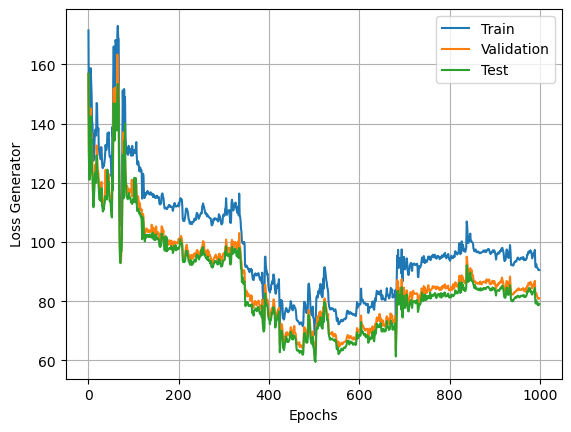

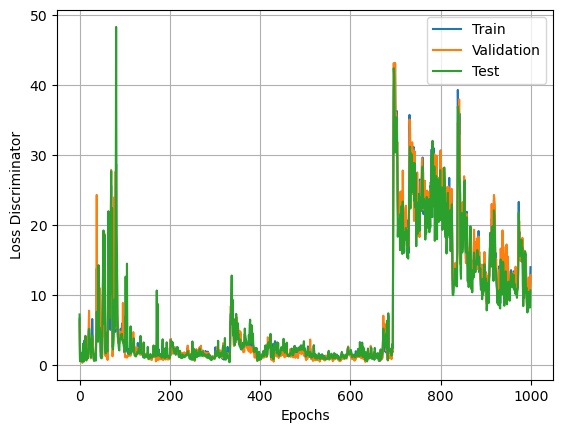

Train Loss Generator:  90.531235
Validation Loss Generator:  80.965454
Test Loss Generator 79.04113
Train Loss Discriminator:  14.028204
Validation Discriminator:  12.915928
Test Discriminator 10.699957


In [15]:
loss_fn_g = Loss_G()
loss_fn_d = Loss_D()
lr = 1e-4
epochs = 1000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
generator, discriminator, train_loss_g, val_loss_g, test_loss_g, train_loss_d, val_loss_d, test_loss_d = train(Generator().to(device), Discriminator().to(device), loss_fn_g, loss_fn_d, lr, epochs, train_loader, val_loader, test_loader, batch_size)

# Save result images

## Train

In [16]:
i = 0
generator.eval()
for visible, ir, mask in train_loader:
    for j in range(len(visible)):
        visible = visible.to(device = device)
        ir = ir.to(device = device)
        with torch.no_grad():
            
            generator_input = torch.cat([visible,ir],dim = 1)
            generator_output = generator(generator_input)
            generator_output = generator_output.cpu()
            generator_output = generator_output[j].permute(1,2,0).numpy()*255
            generator_output = Image.fromarray(generator_output.astype(np.uint8), 'RGB')
            
            
            visible_img = visible.cpu()
            visible_img = visible_img[j].permute(1,2,0).numpy()*255
            visible_img = Image.fromarray(visible_img.astype(np.uint8), 'RGB')
            
            
            ir_img = ir.cpu()
            ir_img = ir_img[j].permute(1,2,0).numpy()*255
            ir_img = Image.fromarray(ir_img.astype(np.uint8), 'RGB')
            
            mask_img = mask.cpu()
            mask_img = mask_img[j].permute(1,2,0).numpy()*255
            mask_img = Image.fromarray(mask_img.astype(np.uint8), 'RGB')
            
            
            generator_output.save("Train_GAN/Result Fusion/"+str(i).zfill(4)+".png")
            visible_img.save("Train_GAN/Visible/"+str(i).zfill(4)+".png")
            ir_img.save("Train_GAN/IR/"+str(i).zfill(4)+".png")
            mask_img.save("Train_GAN/Mask/"+str(i).zfill(4)+".png")
            
            i += 1
            
            

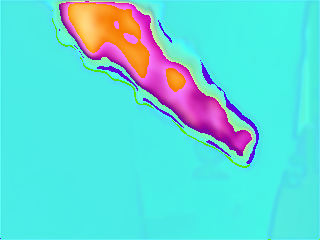

In [17]:
example_train = Image.open('Train_GAN/Result Fusion/0000.png')
example_train

## Test

In [18]:
i = 0
generator.eval()
for visible, ir, mask in test_loader:
    for j in range(len(visible)):
        visible = visible.to(device = device)
        ir = ir.to(device = device)
        with torch.no_grad():
            
            generator_input = torch.cat([visible,ir],dim = 1)
            generator_output = generator(generator_input)
            generator_output = generator_output.cpu()
            generator_output = generator_output[j].permute(1,2,0).numpy()*255
            generator_output = Image.fromarray(generator_output.astype(np.uint8), 'RGB')
            
            
            visible_img = visible.cpu()
            visible_img = visible_img[j].permute(1,2,0).numpy()*255
            visible_img = Image.fromarray(visible_img.astype(np.uint8), 'RGB')
            
            
            ir_img = ir.cpu()
            ir_img = ir_img[j].permute(1,2,0).numpy()*255
            ir_img = Image.fromarray(ir_img.astype(np.uint8), 'RGB')
            
            mask_img = mask.cpu()
            mask_img = mask_img[j].permute(1,2,0).numpy()*255
            mask_img = Image.fromarray(mask_img.astype(np.uint8), 'RGB')
            
            
            generator_output.save("Test_GAN/Result Fusion/"+str(i).zfill(4)+".png")
            visible_img.save("Test_GAN/Visible/"+str(i).zfill(4)+".png")
            ir_img.save("Test_GAN/IR/"+str(i).zfill(4)+".png")
            mask_img.save("Test_GAN/Mask/"+str(i).zfill(4)+".png")
            
            i += 1
            
            

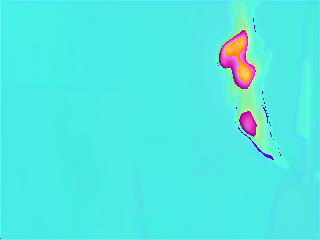

In [19]:
example_test = Image.open('Test_GAN/Result Fusion/0000.png')
example_test

## Val

In [20]:
i = 0
generator.eval()
for visible, ir, mask in val_loader:
    for j in range(len(visible)):
        visible = visible.to(device = device)
        ir = ir.to(device = device)
        with torch.no_grad():
            
            generator_input = torch.cat([visible,ir],dim = 1)
            generator_output = generator(generator_input)
            generator_output = generator_output.cpu()
            generator_output = generator_output[j].permute(1,2,0).numpy()*255
            generator_output = Image.fromarray(generator_output.astype(np.uint8), 'RGB')
            
            
            visible_img = visible.cpu()
            visible_img = visible_img[j].permute(1,2,0).numpy()*255
            visible_img = Image.fromarray(visible_img.astype(np.uint8), 'RGB')
            
            
            ir_img = ir.cpu()
            ir_img = ir_img[j].permute(1,2,0).numpy()*255
            ir_img = Image.fromarray(ir_img.astype(np.uint8), 'RGB')
            
            mask_img = mask.cpu()
            mask_img = mask_img[j].permute(1,2,0).numpy()*255
            mask_img = Image.fromarray(mask_img.astype(np.uint8), 'RGB')
            
            
            generator_output.save("Val_GAN/Result Fusion/"+str(i).zfill(4)+".png")
            visible_img.save("Val_GAN/Visible/"+str(i).zfill(4)+".png")
            ir_img.save("Val_GAN/IR/"+str(i).zfill(4)+".png")
            mask_img.save("Val_GAN/Mask/"+str(i).zfill(4)+".png")
            
            i += 1
            
            

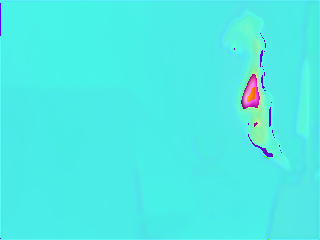

In [21]:
example_val = Image.open('Val_GAN/Result Fusion/0000.png')
example_val

# Save Model

In [22]:
torch.save(generator, "Generator_Model_Checkpoint.pt")